# Generating the Points of the Circle

### Import necessary libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial import Voronoi, ConvexHull, voronoi_plot_2d
import time
import seaborn as sns

Generates a point set along a circle, adding noise and shape error.

Parameters:
- **center**: Coordinates of the circle's center (x, y).
- **radius**: The radius of the circle.
- **num_points**: The number of points to generate.
- **noise_level**: The level of random noise (between 0 and 1).
- **shape_error_params**:
 - **a**: The semi-major axis of the ellipse.
 - **b**: The semi-minor axis of the ellipse.

Return value:
    A numpy array containing the generated points.

In [16]:
def generate_points(center, radius, num_points, noise_level, shape_error=None, shape_error_param=None):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    points = np.zeros((num_points, 2))

    if shape_error is None:
        points[:, 0] = center[0] + radius * np.cos(angles)
        points[:, 1] = center[1] + radius * np.sin(angles)
    elif shape_error == "ellipse":
        a = shape_error_param.get('a', 0.8)
        b = shape_error_param.get('b', 1.2)
        points[:, 0] = center[0] + a * radius * np.cos(angles)
        points[:, 1] = center[1] + b * radius * np.sin(angles)

    points += np.random.normal(0, noise_level * radius, points.shape)

    return points

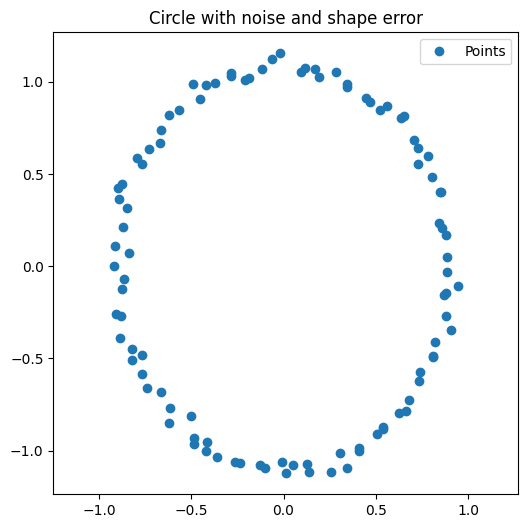

In [17]:
points = generate_points(center=(0, 0), radius=1, num_points=100, noise_level=0.03, shape_error="ellipse", shape_error_param={'a': 0.9, 'b': 1.1})
title = 'Circle with noise and shape error'
plt.figure(figsize=(6, 6))
plt.plot(points[:, 0], points[:, 1], 'o', label='Points')
plt.axis('equal')
plt.title(title)
plt.legend(loc='upper right')
plt.show()

### Parameters

In [18]:
num_points_list = [20, 50, 100]
noise_levels = [0.01, 0.04, 0.07]
shape_errors = [None, "ellipse"]
shape_error_params = ({'a': 0.9, 'b': 1.1})
x_0 = 0
y_0 = 0
rad = 1
iterations = 1

### Generation of points and dataframe

In [19]:
data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)

### Drawing the original circle and points with errors

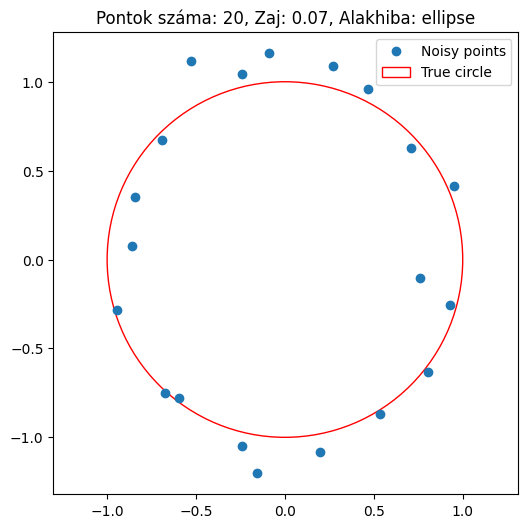

In [ ]:
plotted_row = 5
points = df.iloc[plotted_row]['points']
center = df.iloc[plotted_row]['center']
num_points = df.iloc[plotted_row]['num_points']
noise_level = df.iloc[plotted_row]['noise_level']
r = df.iloc[plotted_row]['radius']
title = f'Number of Points: {num_points}, Noise: {noise_level}, Shape Error: {shape_error}'

plt.figure(figsize=(6, 6))
plt.plot(points[:, 0], points[:, 1], 'o', label='Noisy points')
circle = plt.Circle(center, r, color='r', fill=False, label='True circle')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.title(title)
plt.legend(loc='upper right')
plt.show()

# Fitting a Circle Using the Least Squares Method

## Introduction
The least squares method is a commonly used technique in the mathematical processing of measurements, aimed at minimizing the sum of squared deviations.

## Steps

### 1. Circle Equation
The equation of a circle can be written in the following form:
$$
(x - x_0)^2 + (y - y_0)^2 = r^2
$$
where $(x_0, y_0)$ is the center of the circle and $r$ is the radius.

### 2. Defining the Error Function
The error function is the sum of the squares of the differences between the distance of each point from the center and the radius:
$$
E(x_0, y_0, r) = \sum_{i=1}^{n} \left( \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2} - r \right)^2
$$

### 3. Minimizing the Error Function
The goal is to minimize the error function $E(x_0, y_0, r)$. To do this, we differentiate the error function with respect to $x_0$, $y_0$, and $r$, and then solve the following system of equations:
$$
\frac{\partial E}{\partial x_0} = 0, \quad \frac{\partial E}{\partial y_0} = 0, \quad \frac{\partial E}{\partial r} = 0
$$

### The error function

In [22]:
def error(params, points):
    x_0, y_0, r = params
    return np.sum((np.sqrt((points[:, 0] - x_0)**2 + (points[:, 1] - y_0)**2) - r)**2)

## The jac Function and Equations

The `jac` function calculates the gradient of the error function used.

**The distances:**
$$
d_i = \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2}
$$

**The gradient components:**
$$
\frac{\partial E}{\partial x_0} = -2 \sum_{i=1}^{n} \frac{(d_i - r)(x_i - x_0)}{d_i}
$$
$$
\frac{\partial E}{\partial y_0} = -2 \sum_{i=1}^{n} \frac{(d_i - r)(y_i - y_0)}{d_i}
$$
$$
\frac{\partial E}{\partial r} = 2 \sum_{i=1}^{n} (r - d_i)
$$

**The gradient:**

$$
\nabla E = \begin{bmatrix}
\frac{\partial E}{\partial x_0} \\
\frac{\partial E}{\partial y_0} \\
\frac{\partial E}{\partial r}
\end{bmatrix}
$$

In [ ]:
def safe_divide(numerator, denominator):
    """Biztonságos osztás, amely elkerüli az osztást nullával."""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.true_divide(numerator, denominator)
        result[~np.isfinite(result)] = 0  # -inf, inf, NaN
    return result

def jac(params, points):
    x_0, y_0, r = params
    distances = np.sqrt((points[:, 0] - x_0)**2 + (points[:, 1] - y_0)**2)
    dE_dx0 = -2 * np.sum((distances - r) * safe_divide(points[:, 0] - x_0, distances))
    dE_dy0 = -2 * np.sum((distances - r) * safe_divide(points[:, 1] - y_0, distances))
    dE_dr = 2 * np.sum(r - distances)
    return np.array([dE_dx0, dE_dy0, dE_dr])

## Description of the `process_row` function

The function performs the following steps:

1. Extracts the points from the row.
2. Determines the initial estimate (`initial_guess`) of the circle's center and radius, which is [0, 0, 1] if the second argument is false. If true, it extracts the initial center and radius from the coordinates of the first and opposite measurement points.
3. Optimizes the circle's parameters (center and radius) using the `minimize` function.
4. The `minimize` function returns the optimized parameters (`x_0`, `y_0`, `r`), which are added to the row.

### How the `minimize` function works

The `minimize` function is part of the SciPy library and its purpose is to find the minimum of a given function. The `minimize` function accepts the following parameters:

- `fun`: The objective function to be optimized.
- `x0`: The initial estimate of the parameters.
- `args`: Additional arguments for the objective function.
- `jac`: The jac parameter in the scipy.optimize.minimize function allows us to provide the Jacobian matrix of the objective function. This function should accept the same arguments as the objective function and return a NumPy array representing the Jacobian matrix. This matrix helps to speed up and improve the accuracy of the optimization process.
- `method`: The method parameter determines which optimization algorithm the minimize function uses. The choice of algorithm depends on the problem, the properties of the objective function, and the accuracy of the initial estimate. BFGS is a quasi-Newton method that uses an approximation of the Hessian matrix. This method is worth using if the objective function is differentiable, which is the case. If the objective function is differentiable, the BFGS method may find the optimal solution faster than other methods.

The `minimize` function returns a result object that contains the optimized parameters (`x`), the success of the optimization (`success`), and other information about the optimization.

In [24]:
def process_row(row, use_initial_guess):
    points = row['points']
    
    if use_initial_guess:
        # Calculate initial guess based on two opposite points
        point1 = points[0]
        point2 = points[len(points) // 2]
        x_0 = (point1[0] + point2[0]) / 2
        y_0 = (point1[1] + point2[1]) / 2
        r = ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5 / 2
        initial_guess = [x_0, y_0, r]
    else:
        # Default initial guess
        initial_guess = [0, 0, 1]

    start_time = time.time()
    result = minimize(error, initial_guess, args=(points,), jac=jac, method='BFGS')
    end_time = time.time()
    
    x_0, y_0, r = result.x
    row['initial_x_0'] = initial_guess[0]
    row['initial_y_0'] = initial_guess[1]
    row['initial_r'] = initial_guess[2]
    row['x_0'] = x_0
    row['y_0'] = y_0
    row['r'] = r
    row['error'] = result.fun
    row['fit_runtime'] = end_time - start_time
    
    return row

# How the BFGS Method Works

1. Selecting an Initial Point: The algorithm starts with an initial point, which can be a randomly selected point or a predetermined starting value *(initial_guess)*.
2. Calculating the Gradient: The algorithm calculates the gradient of the function at the current point. The gradient is a vector that shows the slope of the function in every direction.
3. Estimating the Hessian: The Hessian is a matrix that contains the second derivatives of the function. The BFGS algorithm does not calculate the Hessian explicitly, but estimates it iteratively.
4. Determining the Direction: Based on the current gradient and the estimated Hessian, the algorithm determines the direction of the next step. This direction is the direction of the steepest descent.
5. Determining the Step Size: The algorithm performs a line search to find the optimal step size in the given direction.
6. Updating: The algorithm updates the current point with the new point, and also updates the Hessian matrix based on the new information.
7. Checking for Convergence: The algorithm checks whether the solution has converged, i.e., whether the gradient is small enough. If so, the algorithm stops; if not, it returns to step 2.

### Why is it suitable?
- Fast Convergence: Especially when the function behaves well (e.g., smooth and quadratically approximated). This means that fewer iterations are needed to find the solution, which saves time.
- Using the Gradient: It uses the gradient of the function during optimization. If the gradient is easy to calculate, the method can efficiently use this information for faster convergence.
- No Need for an Explicit Hessian: It iteratively estimates the Hessian matrix, so it is not necessary to calculate it explicitly. This can be especially useful if calculating the Hessian would be complex or time-consuming.

### Process the rows

In [25]:
df['x_0'] = np.nan
df['y_0'] = np.nan
df['r'] = np.nan

In [26]:
df=df.apply(lambda row: process_row(row, use_initial_guess=True), axis=1)

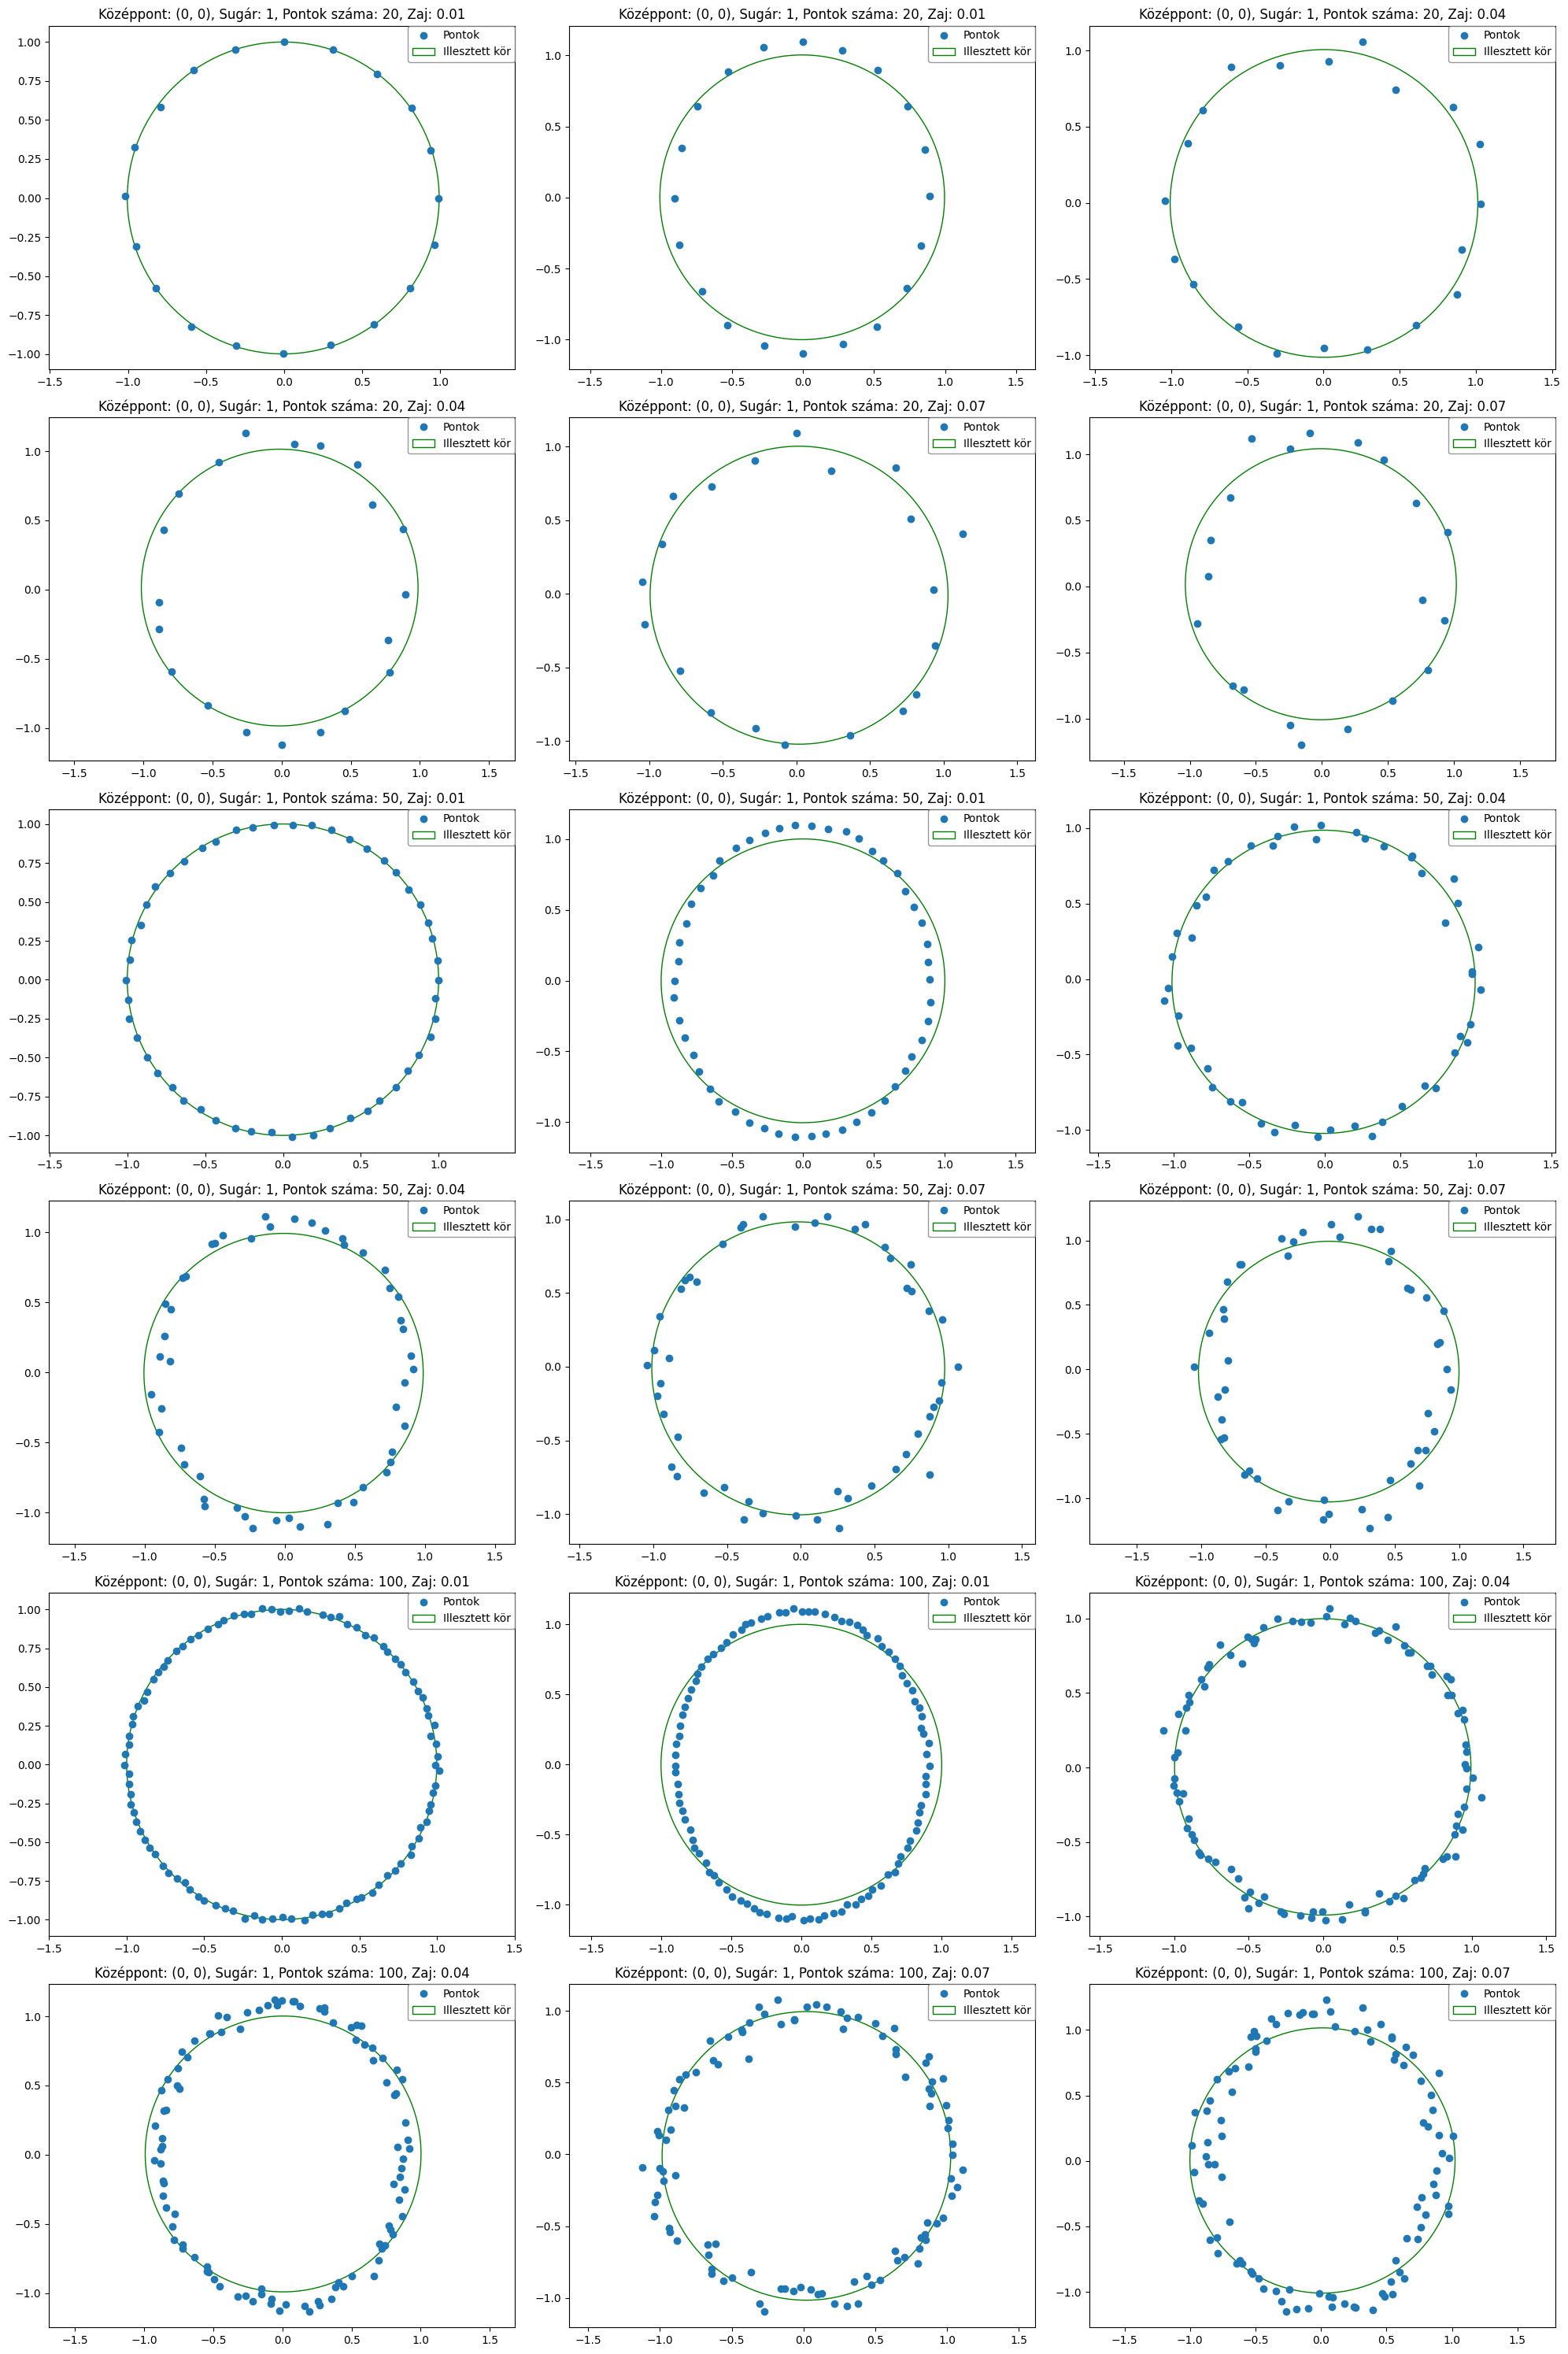

In [ ]:
num_plots = len(df)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i + 1)
    points = df.iloc[i]['points']
    center = df.iloc[i]['center']
    x_0 = df.iloc[i]['x_0']
    y_0 = df.iloc[i]['y_0']
    r = df.iloc[i]['r']
    radius = df.iloc[i]['radius']
    num_points = df.iloc[i]['num_points']
    noise_level = df.iloc[i]['noise_level']
    plt.plot(points[:, 0], points[:, 1], 'o', label='Points')
    fitted_circle = plt.Circle((x_0, y_0), r, color='g', fill=False, label='Fitted circle')
    plt.gca().add_artist(fitted_circle)
    title = f'Center: {center}, Radius: {radius}, Number of points: {num_points}, Noise: {noise_level}'
    plt.title(title)
    plt.axis('equal')
    legend = plt.legend(loc='upper right', borderaxespad=0.)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')

plt.tight_layout()
plt.show()

## Evaluation
### Effect of Variance on Runtime and Error

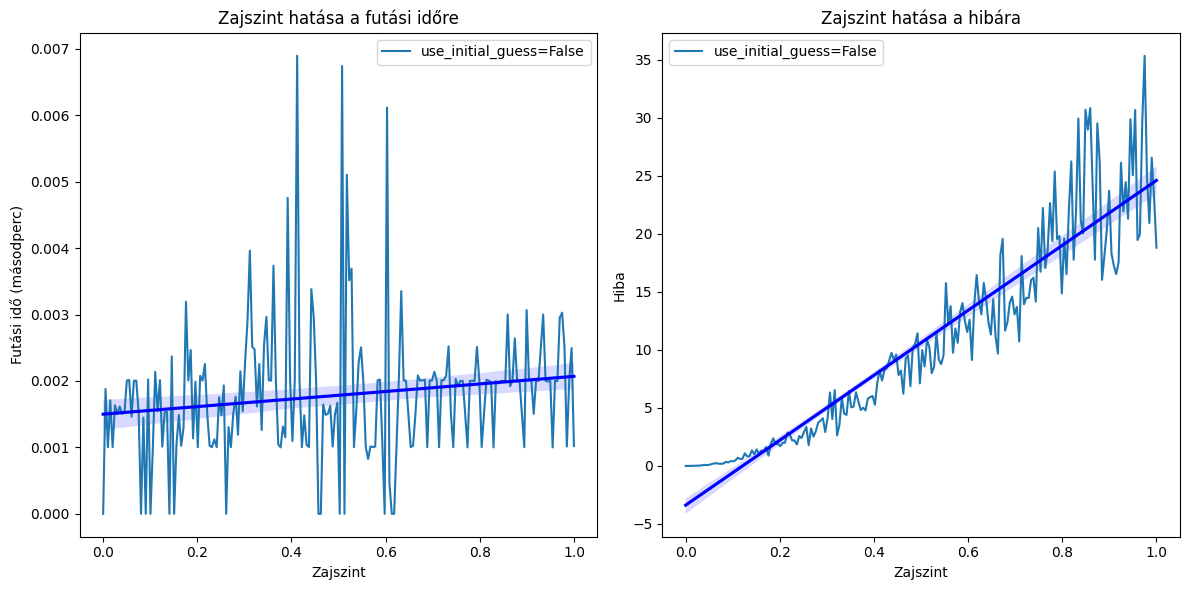

In [ ]:
num_points_list = [50]
noise_levels = np.linspace(0, 1, 200)
shape_errors = [None]
shape_error_params = {'a': 0.9, 'b': 1.1}
x_0 = 0
y_0 = 0
rad = 1
iterations = 1

data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)

df['x_0'] = np.nan
df['y_0'] = np.nan
df['r'] = np.nan

# Process each row for use_initial_guess=False
df_false = df.copy()
df_false = df_false.apply(lambda row: process_row(row, use_initial_guess=False), axis=1)
df_false['use_initial_guess'] = False

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot runtime
plt.subplot(1, 2, 1)
sns.lineplot(x='noise_level', y='fit_runtime', data=df_false, label='use_initial_guess=False')
sns.regplot(x='noise_level', y='fit_runtime', data=df_false, scatter=False, label='Trendline False', color='blue')
plt.title('Effect of Noise Level on Runtime')
plt.xlabel('Noise Level')
plt.ylabel('Runtime (seconds)')

plt.subplot(1, 2, 2)
sns.lineplot(x='noise_level', y='error', data=df_false, label='use_initial_guess=False')
sns.regplot(x='noise_level', y='error', data=df_false, scatter=False, label='Trendline False', color='blue')
plt.title('Effect of Noise Level on Error')
plt.xlabel('Noise Level')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

### Effect of Circle Center and Radius and the Usefulness of Initial Guess

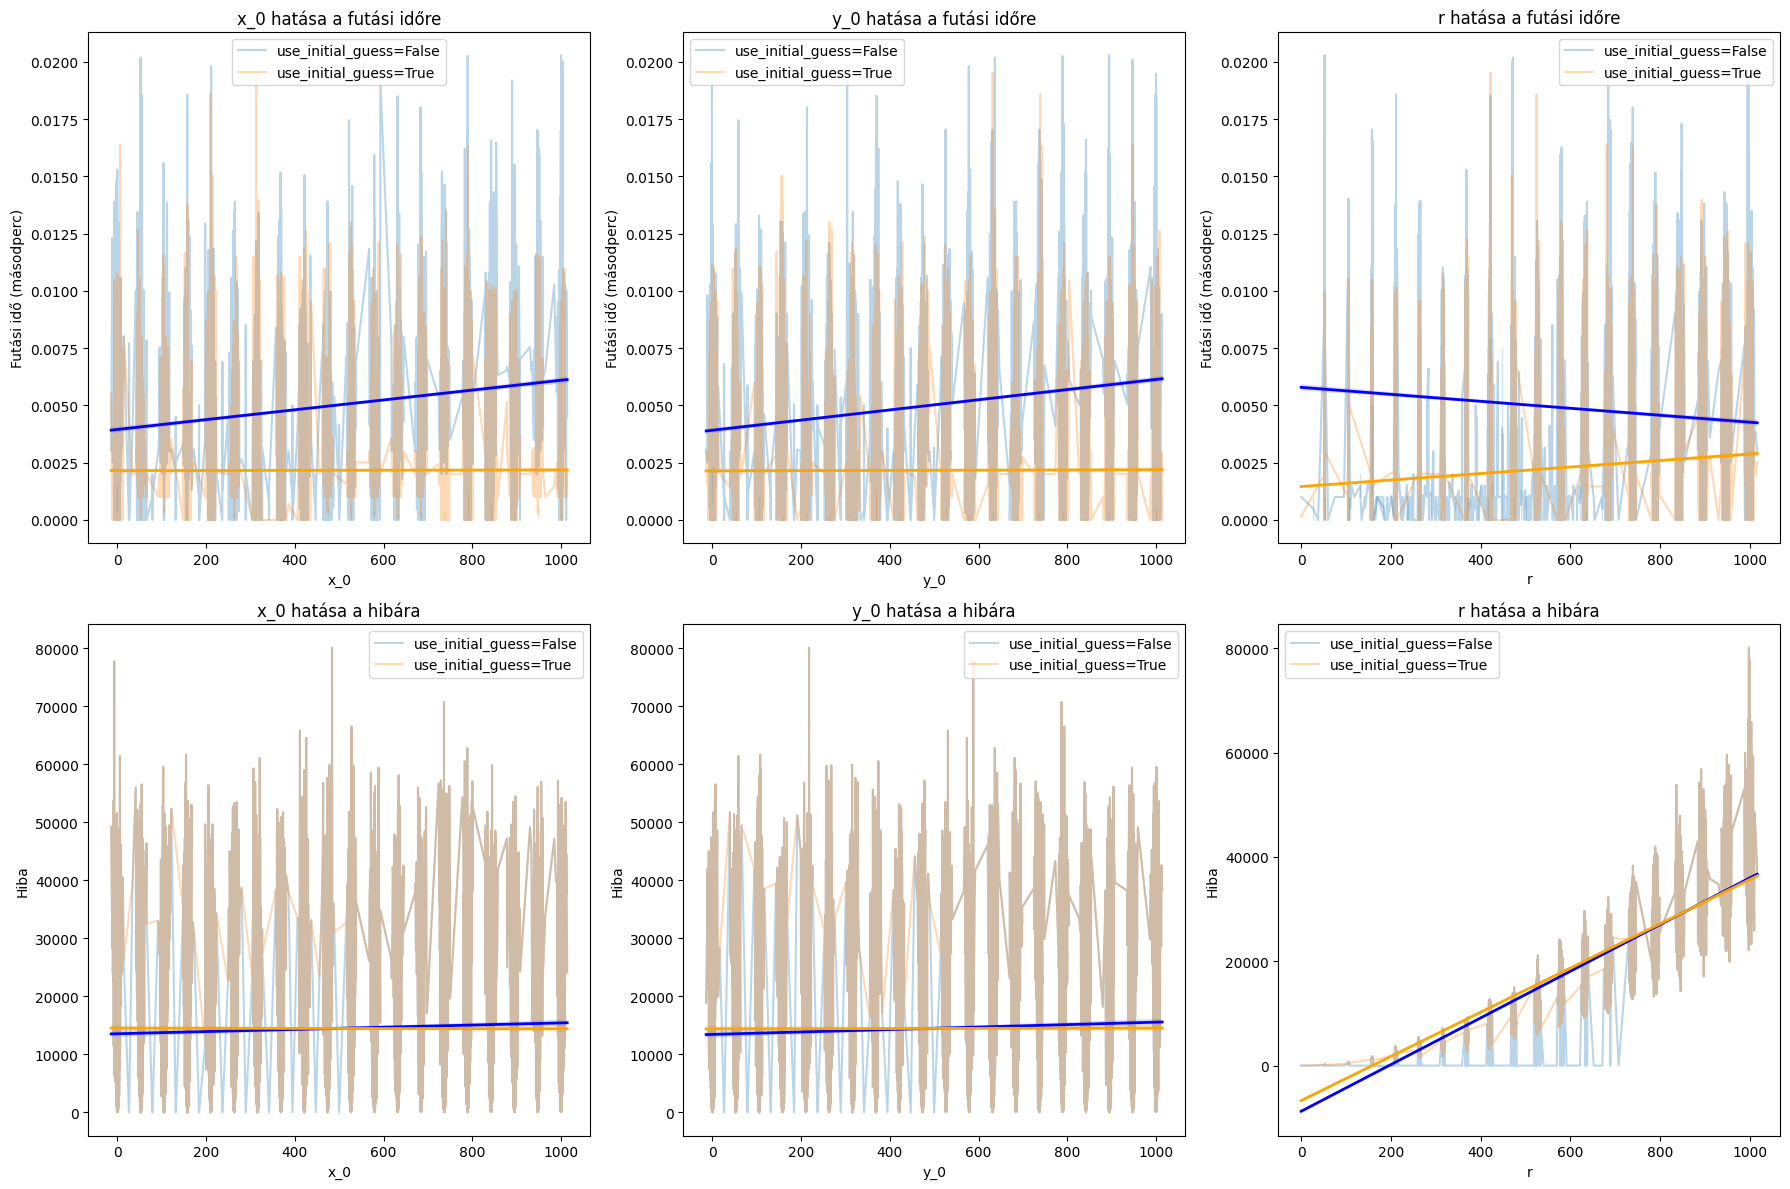

In [ ]:
num_points_list = [50]
noise_levels = [0.03]
shape_errors = [None]
shape_error_params = {'a': 0.9, 'b': 1.1}
x_0_list = np.linspace(0, 1000, 20)
y_0_list = np.linspace(0, 1000, 20)
rad_list = np.linspace(0, 1000, 20)
iterations = 1

data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for x_0 in x_0_list:
                for y_0 in y_0_list:
                    for rad in rad_list:
                        for _ in range(iterations):
                            points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                            data.append({
                                'center': (x_0, y_0),
                                'radius': rad,
                                'num_points': num_points,
                                'noise_level': noise_level,
                                'shape_error': shape_error,
                                'shape_error_params': shape_error == "ellipse" and shape_error_params or None,
                                'points': points
                            })

df = pd.DataFrame(data)

df['x_0'] = np.nan
df['y_0'] = np.nan
df['r'] = np.nan

# Process each row for use_initial_guess=False
df_false = df.copy()
df_false = df_false.apply(lambda row: process_row(row, use_initial_guess=False), axis=1)
df_false['use_initial_guess'] = False

# Process each row for use_initial_guess=True
df_true = df.copy()
df_true = df_true.apply(lambda row: process_row(row, use_initial_guess=True), axis=1)
df_true['use_initial_guess'] = True

# Visualize the results
plt.figure(figsize=(18, 12))

# Plot runtime
plt.subplot(2, 3, 1)
sns.lineplot(x='x_0', y='fit_runtime', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='x_0', y='fit_runtime', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='x_0', y='fit_runtime', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
sns.regplot(x='x_0', y='fit_runtime', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
plt.title('Effect of x_0 on Runtime')
plt.xlabel('x_0')
plt.ylabel('Runtime (seconds)')

plt.subplot(2, 3, 2)
sns.lineplot(x='y_0', y='fit_runtime', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='y_0', y='fit_runtime', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='y_0', y='fit_runtime', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
sns.regplot(x='y_0', y='fit_runtime', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
plt.title('Effect of y_0 on Runtime')
plt.xlabel('y_0')
plt.ylabel('Runtime (seconds)')

plt.subplot(2, 3, 3)
sns.lineplot(x='r', y='fit_runtime', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='r', y='fit_runtime', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='r', y='fit_runtime', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
sns.regplot(x='r', y='fit_runtime', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
plt.title('Effect of r on Runtime')
plt.xlabel('r')
plt.ylabel('Runtime (seconds)')

# Plot error
plt.subplot(2, 3, 4)
sns.lineplot(x='x_0', y='error', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='x_0', y='error', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='x_0', y='error', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
sns.regplot(x='x_0', y='error', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
plt.title('Effect of x_0 on Error')
plt.xlabel('x_0')
plt.ylabel('Error')

plt.subplot(2, 3, 5)
sns.lineplot(x='y_0', y='error', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='y_0', y='error', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='y_0', y='error', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
sns.regplot(x='y_0', y='error', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
plt.title('Effect of y_0 on Error')
plt.xlabel('y_0')
plt.ylabel('Error')

plt.subplot(2, 3, 6)
sns.lineplot(x='r', y='error', data=df_false, label='use_initial_guess=False', alpha=0.3)
sns.lineplot(x='r', y='error', data=df_true, label='use_initial_guess=True', alpha=0.3)
sns.regplot(x='r', y='error', data=df_false, scatter=False, label='Trendline False', color='blue', line_kws={"linewidth": 2})
sns.regplot(x='r', y='error', data=df_true, scatter=False, label='Trendline True', color='orange', line_kws={"linewidth": 2})
plt.title('Effect of r on Error')
plt.xlabel('r')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

### Effect of Number of Points on Runtime and Error

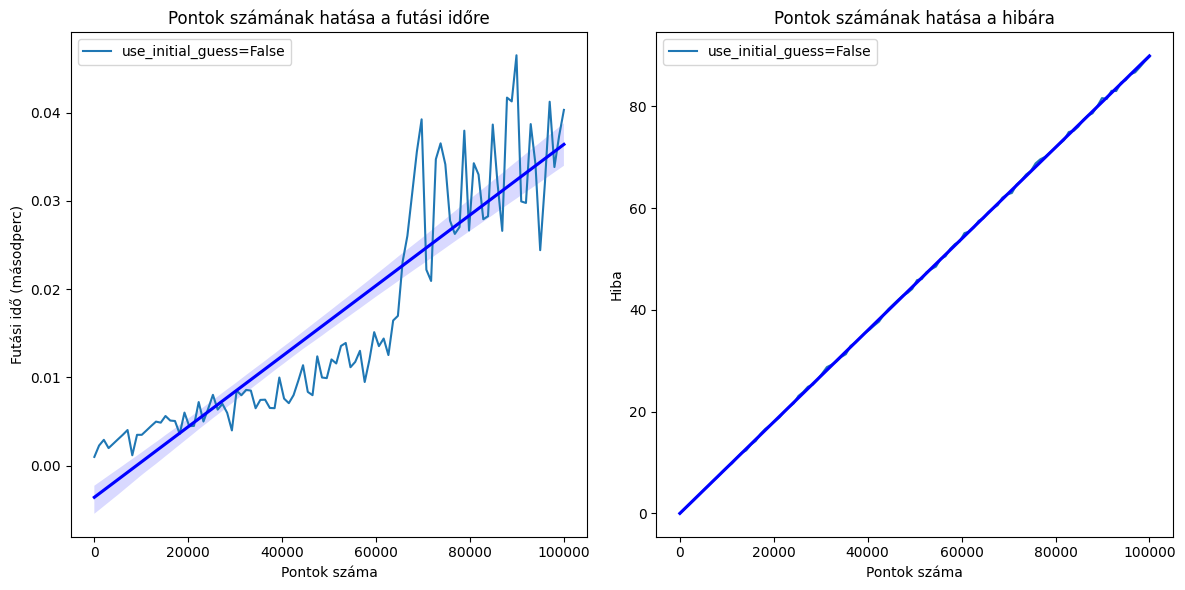

In [ ]:
num_points_list = np.linspace(10, 100000, 100).astype(int)
noise_levels = [0.03]
shape_errors = [None]
shape_error_params = {'a': 0.9, 'b': 1.1}
x_0 = 0
y_0 = 0
rad = 1
iterations = 1

data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)

df['x_0'] = np.nan
df['y_0'] = np.nan
df['r'] = np.nan

# Process each row for use_initial_guess=False
df_false = df.copy()
df_false = df_false.apply(lambda row: process_row(row, use_initial_guess=False), axis=1)
df_false['use_initial_guess'] = False

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot runtime
plt.subplot(1, 2, 1)
sns.lineplot(x='num_points', y='fit_runtime', data=df_false, label='use_initial_guess=False')
sns.regplot(x='num_points', y='fit_runtime', data=df_false, scatter=False, label='Trendline False', color='blue')
plt.title('Effect of Number of Points on Runtime')
plt.xlabel('Number of Points')
plt.ylabel('Runtime (seconds)')

# Plot error
plt.subplot(1, 2, 2)
sns.lineplot(x='num_points', y='error', data=df_false, label='use_initial_guess=False')
sns.regplot(x='num_points', y='error', data=df_false, scatter=False, label='Trendline False', color='blue')
plt.title('Effect of Number of Points on Error')
plt.xlabel('Number of Points')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# Largest Inscribable Circle

## First Solution - Using Constraints and Penalties with the Least Squares Method

In the first solution, we continue to try to solve the problem using the `minimize` function from the SciPy library.

### The Error Function

In this case, we supplement the error function with a penalty term that is added when outside the circle. Its formula is:
$$
E = \sum_{i=1}^{n} \left( \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2} - r \right)^2 + 1000\sum_{i=1}^{n} \max\left(0, r - \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2} \right)
$$

In [31]:
def error_inscribing(params, points):
    x_0, y_0, r = params
    distances = np.sqrt((points[:, 0] - x_0)**2 + (points[:, 1] - y_0)**2)
    errors = ((distances - r)**2)
    penalty = np.sum(np.maximum(0, r - distances)) * 1000
    return np.sum(errors) + penalty

In [45]:
def fit_circle_max_inscribed_penalty(points, initial_center, initial_radius, method='BFGS'):
    start_time = time.time()
    initial_guess = [*initial_center, initial_radius]
    result = minimize(error_inscribing, initial_guess, args=(points,), method=method)
    end_time = time.time()
    runtime = end_time - start_time
    return result.x[:2], result.x[2], runtime

Let's return to the point sets with the original parameters.

In [46]:
num_points_list = [20, 50, 100]
noise_levels = [0.01, 0.04, 0.07]
shape_errors = [None, "ellipse"]
shape_error_params = ({'a': 0.9, 'b': 1.1})
x_0 = 0
y_0 = 0
rad = 1
iterations = 1

In [50]:
data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)

In [51]:
df['max_inscribed_center_penalty'], df['max_inscribed_radius_penalty'], df['max_inscribed_runtime_penalty'] = zip(*df.apply(
    lambda row: fit_circle_max_inscribed_penalty(row['points'], row['center'], row['radius']), axis=1
))

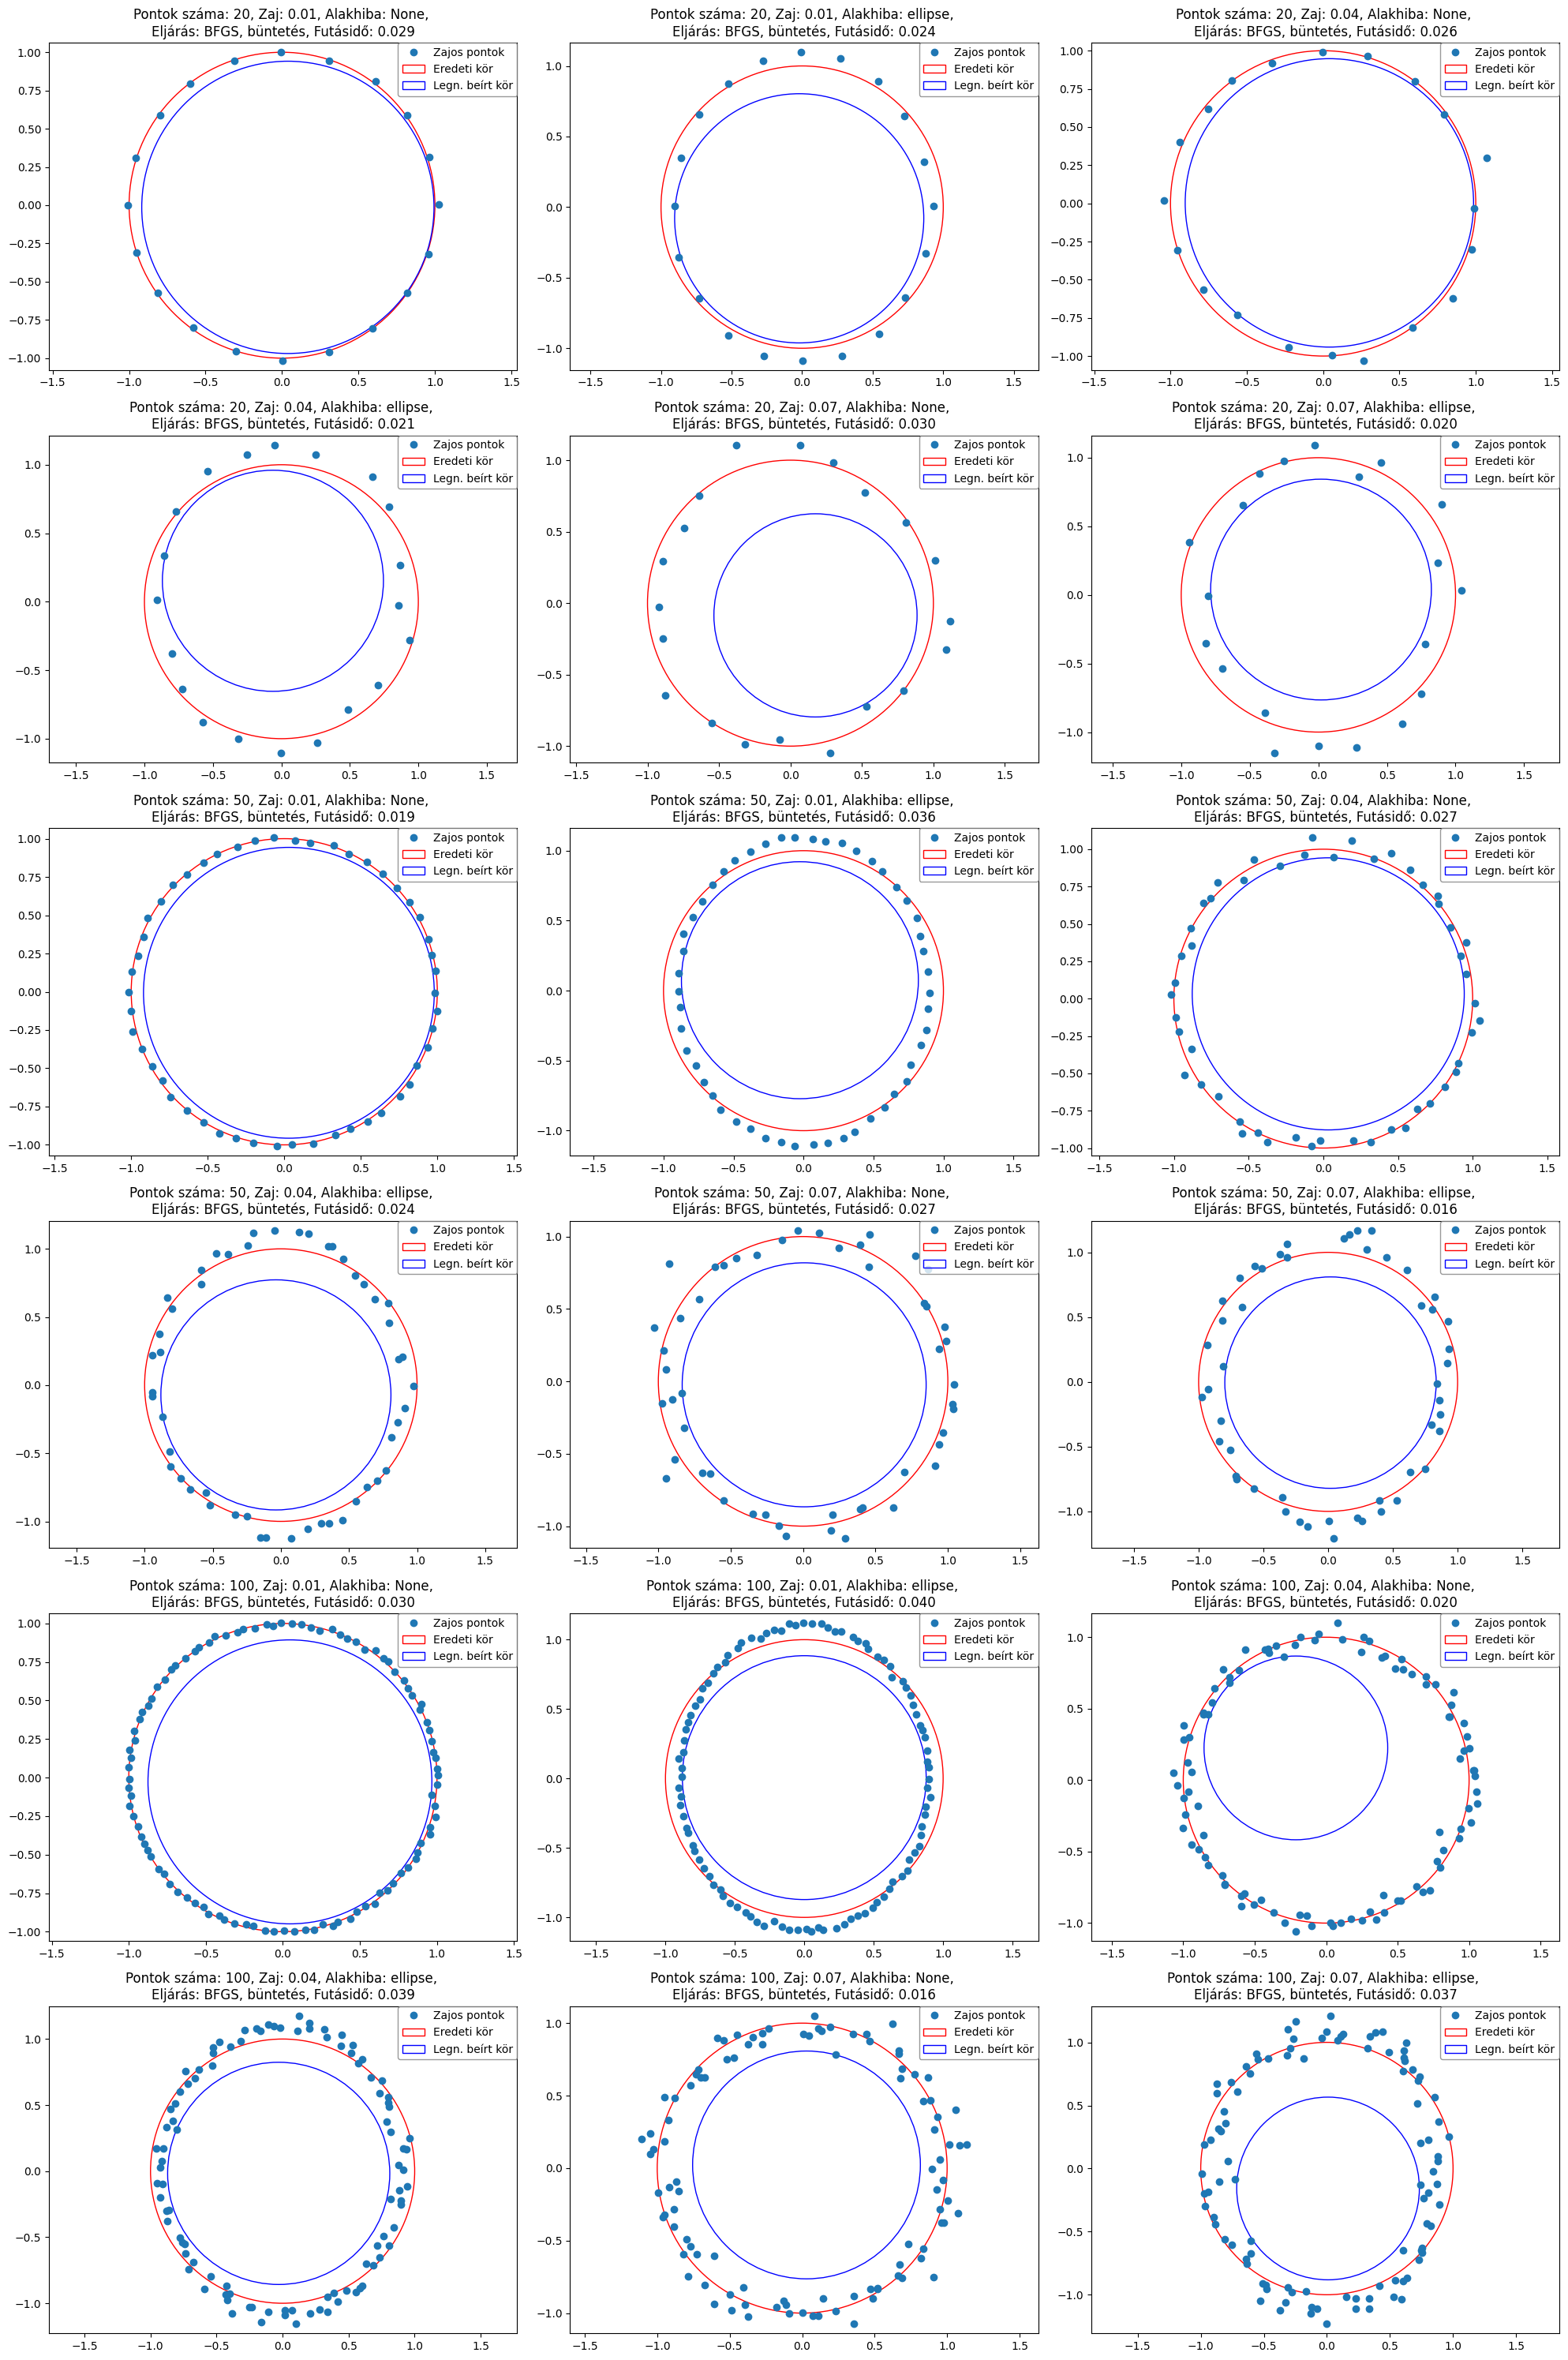

In [ ]:
num_plots = len(df)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for index, row in df.iterrows():
    radius = df.iloc[index]['radius']
    num_points = df.iloc[index]['num_points']
    noise_level = df.iloc[index]['noise_level']
    shape_error = df.iloc[index]['shape_error']
    center = df.iloc[index]['center']

    plt.subplot(num_rows, num_cols, index + 1)
    plt.plot(row['points'][:, 0], row['points'][:, 1], 'o', label='Noisy Points')  # Translated label

    true_circle = plt.Circle(row['center'], row['radius'], color='r', fill=False, label='Original Circle')  # Translated label
    plt.gca().add_artist(true_circle)

    max_inscribed_circle = plt.Circle(row['max_inscribed_center_penalty'], row['max_inscribed_radius_penalty'],
                                        color='b', fill=False, label='Largest Inscribed Circle')  # Translated label
    plt.gca().add_artist(max_inscribed_circle)
    plt.axis('equal')
    legend = plt.legend(loc='upper right', borderaxespad=0.)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    title = f'Number of Points: {num_points}, Noise: {noise_level}, Shape Error: {shape_error}, \nProcedure: BFGS, Penalty, Runtime: {row["max_inscribed_runtime_penalty"]:.3f}'  # Translated title
    plt.title(title)

plt.tight_layout()
plt.show()

## Constraints and Penalties
In addition to penalizing points located inside the circle with the error function, it is also necessary to provide a constraint, as it may happen that despite the penalty, the result is better, i.e., a point falls inside.

In [48]:
def constraint(params):
    x_0, y_0, r = params
    distances = np.sqrt((points[:, 0] - x_0)**2 + (points[:, 1] - y_0)**2)
    return distances - r

This constraint can be given to the previously used minimize function, but in this case, a different method must be used for optimization, as BFGS does not support the use of constraints. The essence of the "trust-constr" method is to iteratively approximate a point that minimizes the objective function while taking into account the given constraints.

## Trust-constr method

1. Trust Region:

    The method defines a trust region around a starting point. This region is a set of points where the model (usually a quadratic approximation) reliably approximates the objective function.
    The size of the region changes from iteration to iteration, depending on how accurately the model describes the objective function.

2. Quadratic Model:

    Within the trust region, the objective function is approximated by a quadratic function. This approximation allows us to solve a simpler problem in the next iteration.
    The quadratic model takes into account the value, gradient, and possibly the Hessian matrix of the objective function at the current point.

3. Constraints:

    The trust-constr method can handle both inequality and equality constraints.
    The constraints are incorporated into the quadratic model, ensuring that the solution always remains within the specified constraints.

4. Solving the Subproblem:

    In each iteration, the method solves a subproblem. The goal of the subproblem is to find the minimum of the quadratic model, taking into account the trust region and the constraints.
    Usually, a quadratic programming (QP) problem is solved to solve the subproblem.

5. Updating the Trust Region:

    The objective function is evaluated at the new point.
    If the actual improvement is close to the improvement predicted by the model, the trust region is increased to speed up convergence.
    If the actual improvement differs significantly from the improvement predicted by the model, the trust region is reduced to make the model more accurate.

6. Repetition:

    Steps 2-5 are repeated until the convergence criteria are met (e.g., the radius of the trust region is small enough).

In [58]:
def fit_circle_max_inscribed_penalty_constrain(points, initial_center, initial_radius, method='trust-constr'):
    start_time = time.time()
    cons = {'type': 'ineq', 'fun': constraint}
    initial_guess = [*initial_center, initial_radius]
    result = minimize(error_inscribing, initial_guess, args=(points,), method=method, constraints=cons)
    end_time = time.time()
    runtime = end_time - start_time
    return result.x[:2], result.x[2], runtime

In [59]:
df['max_inscribed_center_penalty_constrain'], df['max_inscribed_radius_penalty_constrain'], df['max_inscribed_runtime_penalty_constrain'] = zip(*df.apply(
    lambda row: fit_circle_max_inscribed_penalty_constrain(row['points'], row['center'], row['radius']), axis=1
))

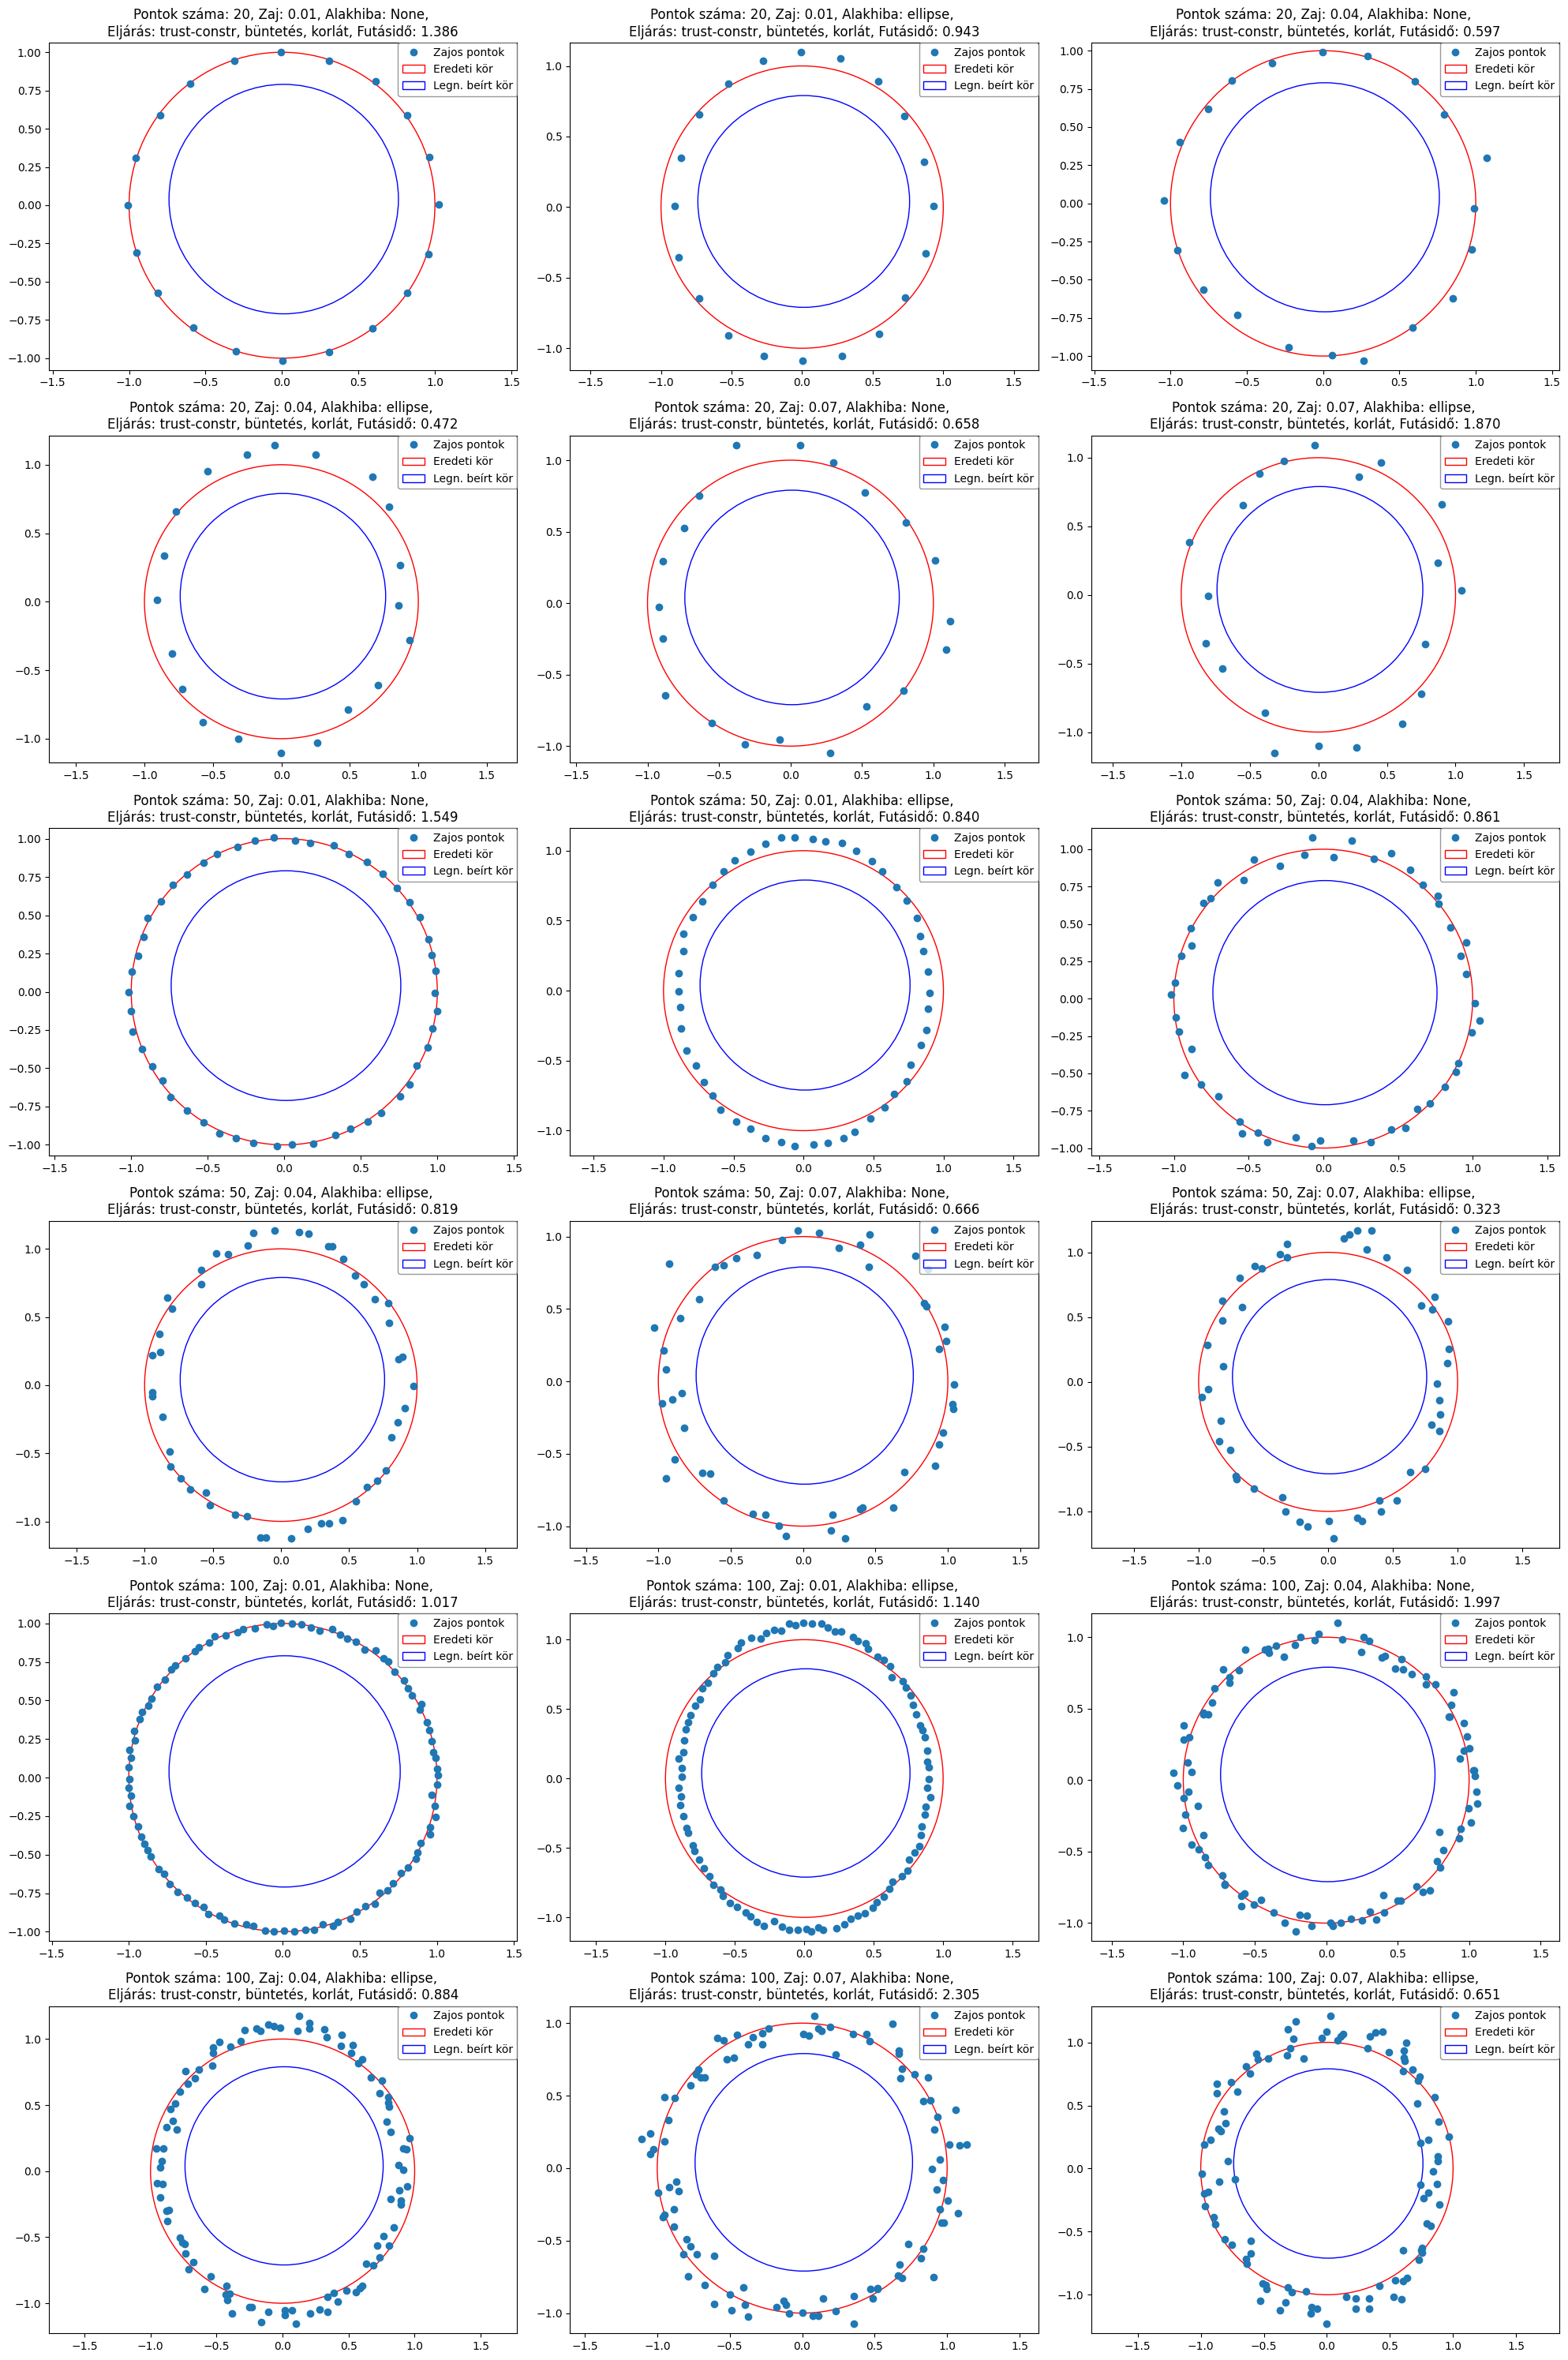

In [ ]:
num_plots = len(df)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for index, row in df.iterrows():
    radius = df.iloc[index]['radius']
    num_points = df.iloc[index]['num_points']
    noise_level = df.iloc[index]['noise_level']
    shape_error = df.iloc[index]['shape_error']
    center = df.iloc[index]['center']

    plt.subplot(num_rows, num_cols, index + 1)
    plt.plot(row['points'][:, 0], row['points'][:, 1], 'o', label='Noisy Points')

    true_circle = plt.Circle(row['center'], row['radius'], color='r', fill=False, label='Original Circle')
    plt.gca().add_artist(true_circle)

    max_inscribed_circle = plt.Circle(row['max_inscribed_center_penalty_constrain'], row['max_inscribed_radius_penalty_constrain'],
                                        color='b', fill=False, label='Largest Inscribed Circle')
    plt.gca().add_artist(max_inscribed_circle)
    plt.axis('equal')
    legend = plt.legend(loc='upper right', borderaxespad=0.)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    title = f'Number of Points: {num_points}, Noise: {noise_level}, Shape Error: {shape_error}, \nProcedure: trust-constr, penalty, constraint, Runtime: {row["max_inscribed_runtime_penalty_constrain"]:.3f}'
    plt.title(title)

plt.tight_layout()
plt.show()

It is noticeable that in many cases, the inscribed circles do not even come close to the point set. Let's also examine the case where we do not use the penalty in the error function, but only provide the constraint.

## Error Function Without Penalty, Using Only Constraints

In [66]:
def fit_circle_max_inscribed_constrain(points, initial_center, initial_radius, method='trust-constr'):
    start_time = time.time()
    cons = {'type': 'ineq', 'fun': constraint}
    initial_guess = [*initial_center, initial_radius]
    result = minimize(error, initial_guess, args=(points,), method=method, constraints=cons)
    end_time = time.time()
    runtime = end_time - start_time
    return result.x[:2], result.x[2], runtime

In [67]:
df['max_inscribed_center_constrain'], df['max_inscribed_radius_constrain'], df['max_inscribed_runtime_constrain'] = zip(*df.apply(
    lambda row: fit_circle_max_inscribed_constrain(row['points'], row['center'], row['radius']), axis=1
))

In [1]:
num_plots = len(df)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for index, row in df.iterrows():
    radius = df.iloc[index]['radius']
    num_points = df.iloc[index]['num_points']
    noise_level = df.iloc[index]['noise_level']
    shape_error = df.iloc[index]['shape_error']
    center = df.iloc[index]['center']

    plt.subplot(num_rows, num_cols, index + 1)
    plt.plot(row['points'][:, 0], row['points'][:, 1], 'o', label='Noisy Points')

    true_circle = plt.Circle(row['center'], row['radius'], color='r', fill=False, label='Original Circle')
    plt.gca().add_artist(true_circle)

    max_inscribed_circle = plt.Circle(row['max_inscribed_center_constrain'], row['max_inscribed_radius_constrain'],
                                        color='b', fill=False, label='Largest Inscribed Circle')
    plt.gca().add_artist(max_inscribed_circle)
    plt.axis('equal')
    legend = plt.legend(loc='upper right', borderaxespad=0.)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    title = f'Number of Points: {num_points}, Noise: {noise_level}, Shape Error: {shape_error}, \nProcedure: trust-constr, constraint, Runtime: {row["max_inscribed_runtime_constrain"]:.3f}'
    plt.title(title)

plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

## Evaluation of the First Solution

As can be seen from the figures, although the above solutions provide seemingly good results in many cases, since they focus on minimizing the error, they do not find the largest inscribable circle. This can easily be deduced from the fact that when a point falls closer to the center than the average, the circle fits that one point, but not other points. Thus, we can say that the above solution does not find the largest inscribed circle, but using the least squares method, it finds the circle that best fits the points and falls within the point set.

For the above reasons, I will not deal with the effects of changing the parameters, since this method does not offer a suitable solution to the problem.

## Second Solution - Convex Hull and Voronoi Diagram

**Convex Hull:**

Given a set of points P. The convex hull of P is the smallest convex set that contains P.

**Voronoi Diagram:**

The Voronoi cell of an element of a point set contains the points in the plane (or space) to which that element is closest from the point set. On the plane, the Voronoi cell of a point can be obtained as the region bounded by the perpendicular bisectors with the other elements of the point set.

**Relationship between Convex Hull, Voronoi Diagram, and Inscribed Circle**

1. Calculate Voronoi Diagram: Calculate the Voronoi diagram of the points.
2. Calculate Convex Hull: Calculate the convex hull of the points.
3. Select Centroids: From the centroids of the Voronoi cells, select those that are inside the convex hull.
4. Calculate Distances: Calculate the distances between the selected centroids and the closest points.
5. Determine Largest Distance: The centroid with the largest distance will be the center of the largest inscribable circle, and the distance will be the radius.

The method guarantees that the found circle is the largest inscribable circle and can be applied to any number of points.

### `is_inside_hull` function

**Description:**

This function determines whether a given point is inside a convex hull.

1. **Create New Convex Hull:** Add the point to be checked to the original convex hull, and then calculate the convex hull of the new point set.
2. **Comparison:** Compare the vertex indices of the new and old convex hulls. If the indices are the same, then the point is inside or on the boundary of the old convex hull.

In [38]:
def is_inside_hull(point, hull):
    new_hull = ConvexHull(np.concatenate((hull.points, [point])))
    return np.array_equal(new_hull.vertices, hull.vertices)

### `largest_inscribed__circle` ###

**Description:**

Finds the largest inscribed circle in a given point set.

### Steps demonstrated through an example:

1. **Calculate Voronoi Diagram:** Calculates the Voronoi diagram of the given points using the `scipy.spatial.Voronoi` class.

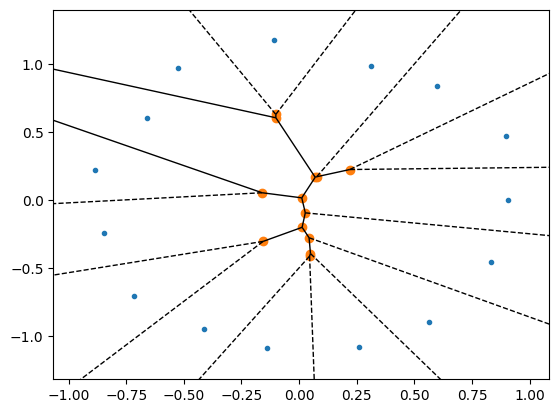

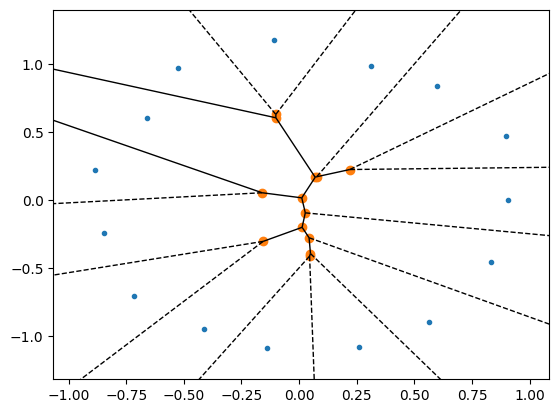

In [76]:
points = generate_points(center=(0, 0), radius=1, num_points=15, noise_level=0.04, shape_error="ellipse", shape_error_param={'a': 0.9, 'b': 1.1})
vor = Voronoi(points)
voronoi_plot_2d(vor)

2. **Calculate Convex Hull:** Calculates the convex hull of the points using the `scipy.spatial.ConvexHull` class. For example, if the points are `[(0, 0), (0, 1), (1, 1), (1, 0)]`, then the convex hull will be the square.

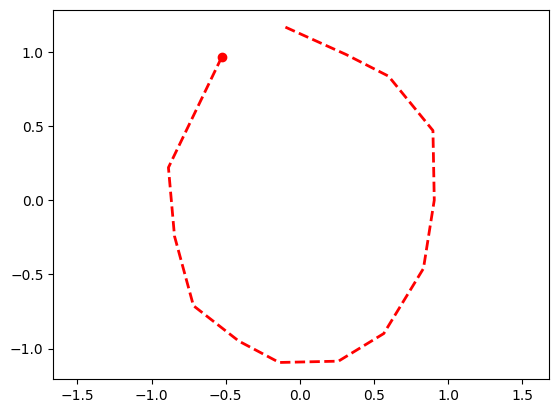

In [77]:
hull = ConvexHull(points)
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r--', lw=2)
plt.plot(points[hull.vertices[0], 0], points[hull.vertices[0], 1], 'ro')
plt.axis('equal')
plt.show()

3. **Filter Voronoi Cell Vertices:** Selects the Voronoi cell vertices that are inside the convex hull. Uses the `is_inside_hull` function to determine this.

In [ ]:
vertices = vor.vertices
inside_hull = np.array([point for point in vertices if is_inside_hull(point, hull)])
plt.plot(points[:, 0], points[:, 1], 'o', label='Points')
plt.plot(inside_hull[:, 0], inside_hull[:, 1], 'o', label='Internal points')
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r--', lw=2)
plt.plot(points[hull.vertices[0], 0], points[hull.vertices[0], 1], 'ro')
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()

NameError: name 'vor' is not defined

4. **Calculate Distances:** Calculates the distances between the selected Voronoi cell vertices and the original points.

In [ ]:
distances = np.linalg.norm(inside_hull[:, np.newaxis] - points, axis=2)
min_distances = np.min(distances, axis=1)

5. **Find Largest Distance:** Finds the Voronoi cell vertex with the largest minimum distance to the original points. This vertex will be the center of the inscribed circle.
The distance between the center and the closest point will be the radius of the inscribed circle.

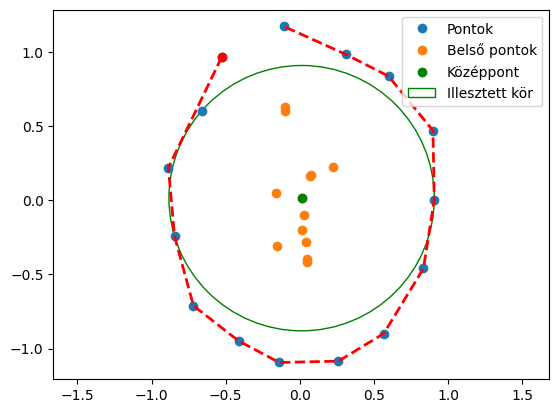

In [ ]:
max_distance_index = np.argmax(min_distances)
center = inside_hull[max_distance_index]
radius = min_distances[max_distance_index]
plt.plot(points[:, 0], points[:, 1], 'o', label='Points')
plt.plot(inside_hull[:, 0], inside_hull[:, 1], 'o', label='Internal Points')
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r--', lw=2)
plt.plot(points[hull.vertices[0], 0], points[hull.vertices[0], 1], 'ro')
plt.plot(center[0], center[1], 'go', label='Center')
circle = plt.Circle(center, radius, color='g', fill=False, label='Fitted Circle')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()

The following function calculates the signed distance of a point from the circle's circumference. As a check, we add this value to the points, but do not include it in the runtime. To determine the accuracy, we use the sum of the distances from the circumference of the three closest points, based on the consideration that, in theory, the inscribable circle fits these three points.

In [133]:
def distance_to_radius(points, center, radius):
    return np.linalg.norm(points - center, axis=1) - radius

The function performing the above steps on an arbitrary point set:

In [134]:
def largest_inscribed_circle(points):
    start_time = time.time()

    vor = Voronoi(points)
    hull = ConvexHull(points)

    vertices = vor.vertices
    inside_hull = np.array([point for point in vertices if is_inside_hull(point, hull)])
    
    distances = np.linalg.norm(inside_hull[:, np.newaxis] - points, axis=2)
    min_distances = np.min(distances, axis=1)
    
    max_distance_index = np.argmax(min_distances)
    center = inside_hull[max_distance_index]
    radius = min_distances[max_distance_index]
    
    end_time = time.time()
    runtime = end_time - start_time
    distances_to_radius = distance_to_radius(points, center, radius)
    accuracy = np.sum(np.sort(distances_to_radius)[:3])
    
    return center, radius, runtime, distances_to_radius, accuracy

#### Generate the points

In [135]:
num_points_list = [20, 50, 100]
noise_levels = [0.01, 0.04, 0.07]
shape_errors = [None, "ellipse"]
shape_error_params = ({'a': 0.9, 'b': 1.1})
x_0 = 0
y_0 = 0
rad = 1
iterations = 1

In [136]:
data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)

#### Applying function to the dataframe

In [137]:
df['max_inscribed_center_voronoi'], df['max_inscribed_radius_voronoi'], df['max_inscribed_runtime_voronoi'], df['max_inscribed_distances_voronoi'], df['accuracy'] = zip(*df['points'].apply(largest_inscribed_circle))

If a point falls inside the circle, we represent it in red.

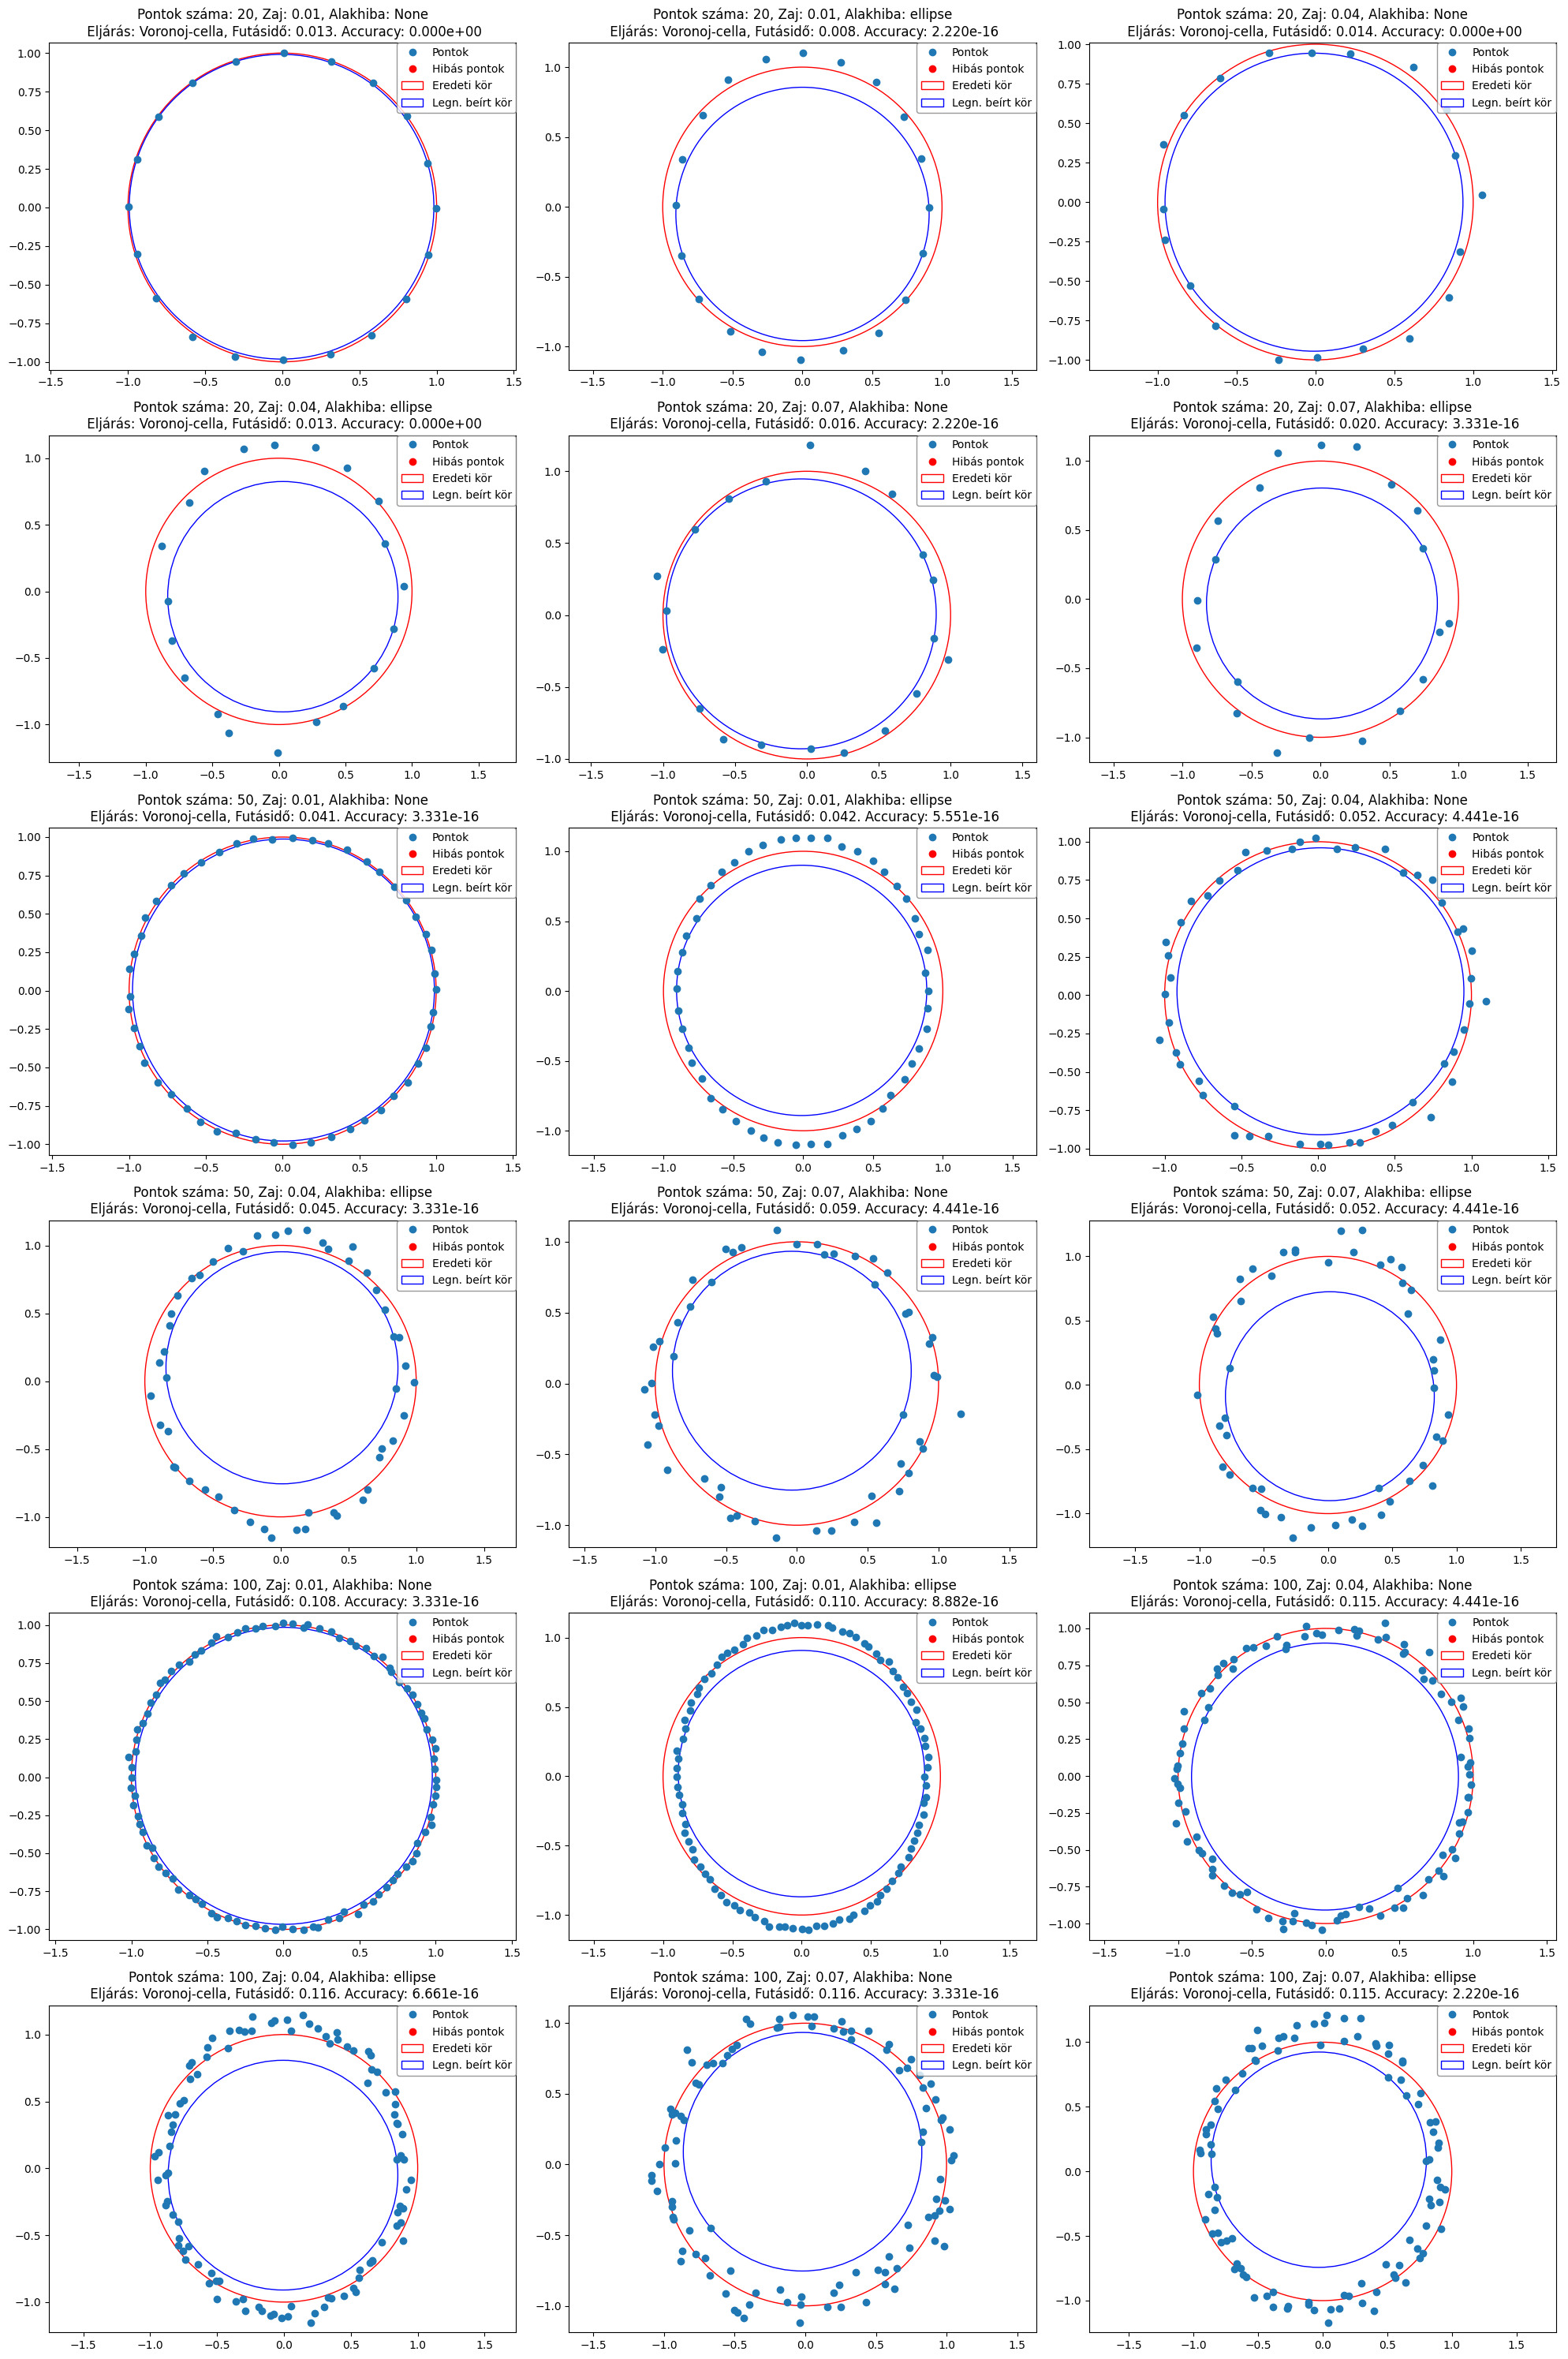

In [ ]:
num_plots = len(df)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for index, row in df.iterrows():
    radius = df.iloc[index]['radius']
    num_points = df.iloc[index]['num_points']
    noise_level = df.iloc[index]['noise_level']
    shape_error = df.iloc[index]['shape_error']
    center = df.iloc[index]['center']

    plt.subplot(num_rows, num_cols, index + 1)

    points = row['points']
    max_inscribed_distances_voronoi = row['max_inscribed_distances_voronoi']
    plt.plot(points[:, 0], points[:, 1], 'o', label='Points')
    plt.plot(points[max_inscribed_distances_voronoi < 0, 0], points[max_inscribed_distances_voronoi < 0, 1], 'ro', label='Error points')


    # Original circle
    true_circle = plt.Circle(row['center'], row['radius'], color='r', fill=False, label='Original circle')
    plt.gca().add_artist(true_circle)

    # Largest inscribed circle
    max_inscribed_circle = plt.Circle(row['max_inscribed_center_voronoi'], row['max_inscribed_radius_voronoi'],
                                      color='b', fill=False, label='Largest inscribed circle')
    plt.gca().add_artist(max_inscribed_circle)

    plt.axis('equal')
    legend = plt.legend(loc='upper right', borderaxespad=0.)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    title = f'Number of points: {num_points}, Noise: {noise_level}, Shape error: {shape_error}\n Method: Voronoi cell, Runtime: {row["max_inscribed_runtime_voronoi"]:.3f}. Accuracy: {row["accuracy"]:.3e}'
    plt.title(title)

plt.tight_layout()
plt.show()

All points fall outside the circle, and the distance of the three closest points from the outline is minimal, so I consider the method to be correct.

Let's perform further analyses on this method.

## Evaluation
### Effect of noise, shape error, and noise level on runtime and accuracy

Let's create a larger dataset to perform the analysis with more reliable data. We will generate 10 point sets for each configuration. The runtimes and accuracies will be analyzed based on the average of the 10 results.

In [157]:
num_points_list = [20, 50, 100, 200, 500, 1000]
noise_levels = np.linspace(0, 0.3, 5)
shape_errors = [None, "ellipse"]
shape_error_params = {'a': 0.9, 'b': 1.1}
x_0 = 0
y_0 = 0
rad = 1
iterations = 10

data = []

for num_points in num_points_list:
    for noise_level in noise_levels:
        for shape_error in shape_errors:
            for _ in range(iterations):
                points = generate_points((x_0, y_0), rad, num_points, noise_level, shape_error, shape_error_params)
                data.append({
                    'center': (x_0, y_0),
                    'radius': rad,
                    'num_points': num_points,
                    'noise_level': noise_level,
                    'shape_error': shape_error,
                    'shape_error_params': shape_error_params if shape_error == "ellipse" else None,
                    'points': points
                })

df = pd.DataFrame(data)
df['max_inscribed_center_voronoi'], df['max_inscribed_radius_voronoi'], df['max_inscribed_runtime_voronoi'], df['max_inscribed_distances_voronoi'], df['accuracy'] = zip(*df['points'].apply(largest_inscribed_circle))


Means

In [172]:
df['shape_error'] = df['shape_error'].apply(lambda x: 'None' if x is None else x)

df_mean = df.groupby(['num_points', 'noise_level', 'shape_error']).agg({'accuracy': 'mean', 'max_inscribed_runtime_voronoi': 'mean'}).reset_index()

Visualization

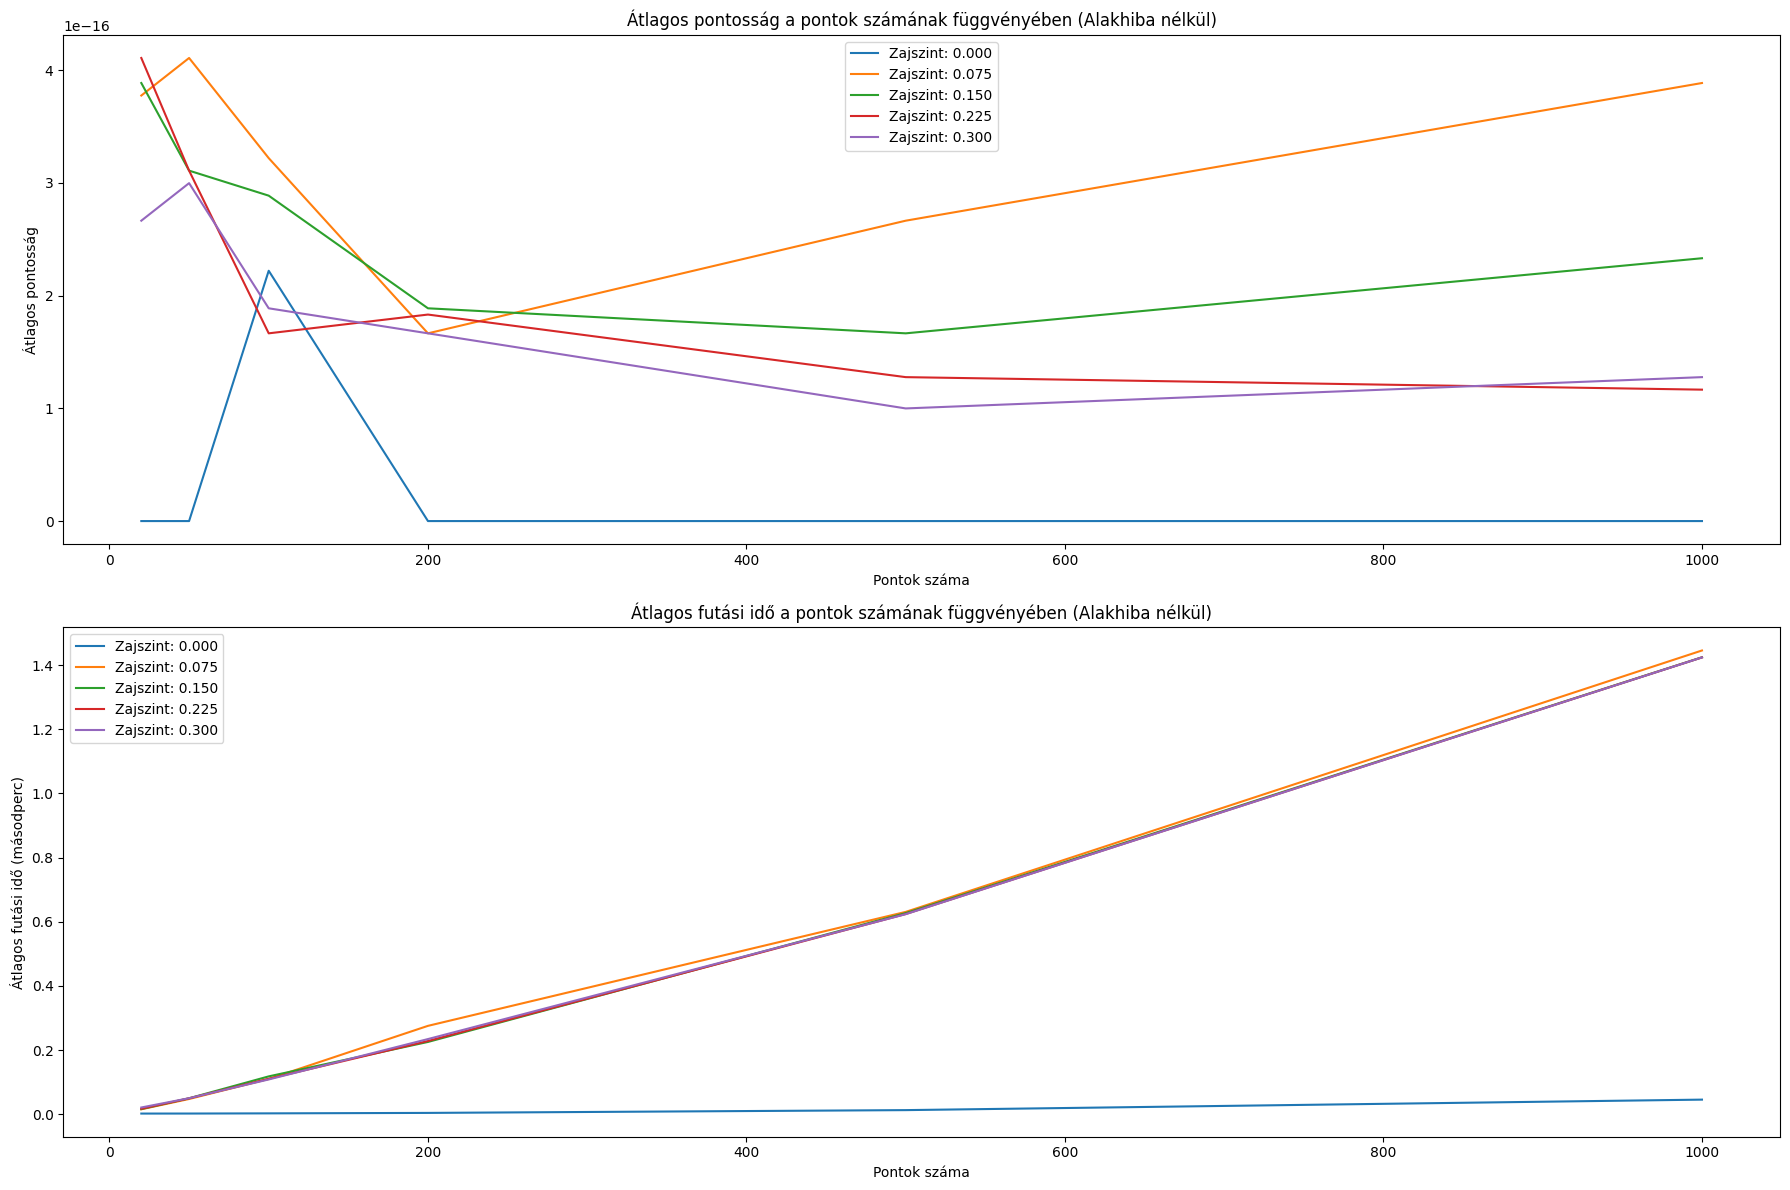

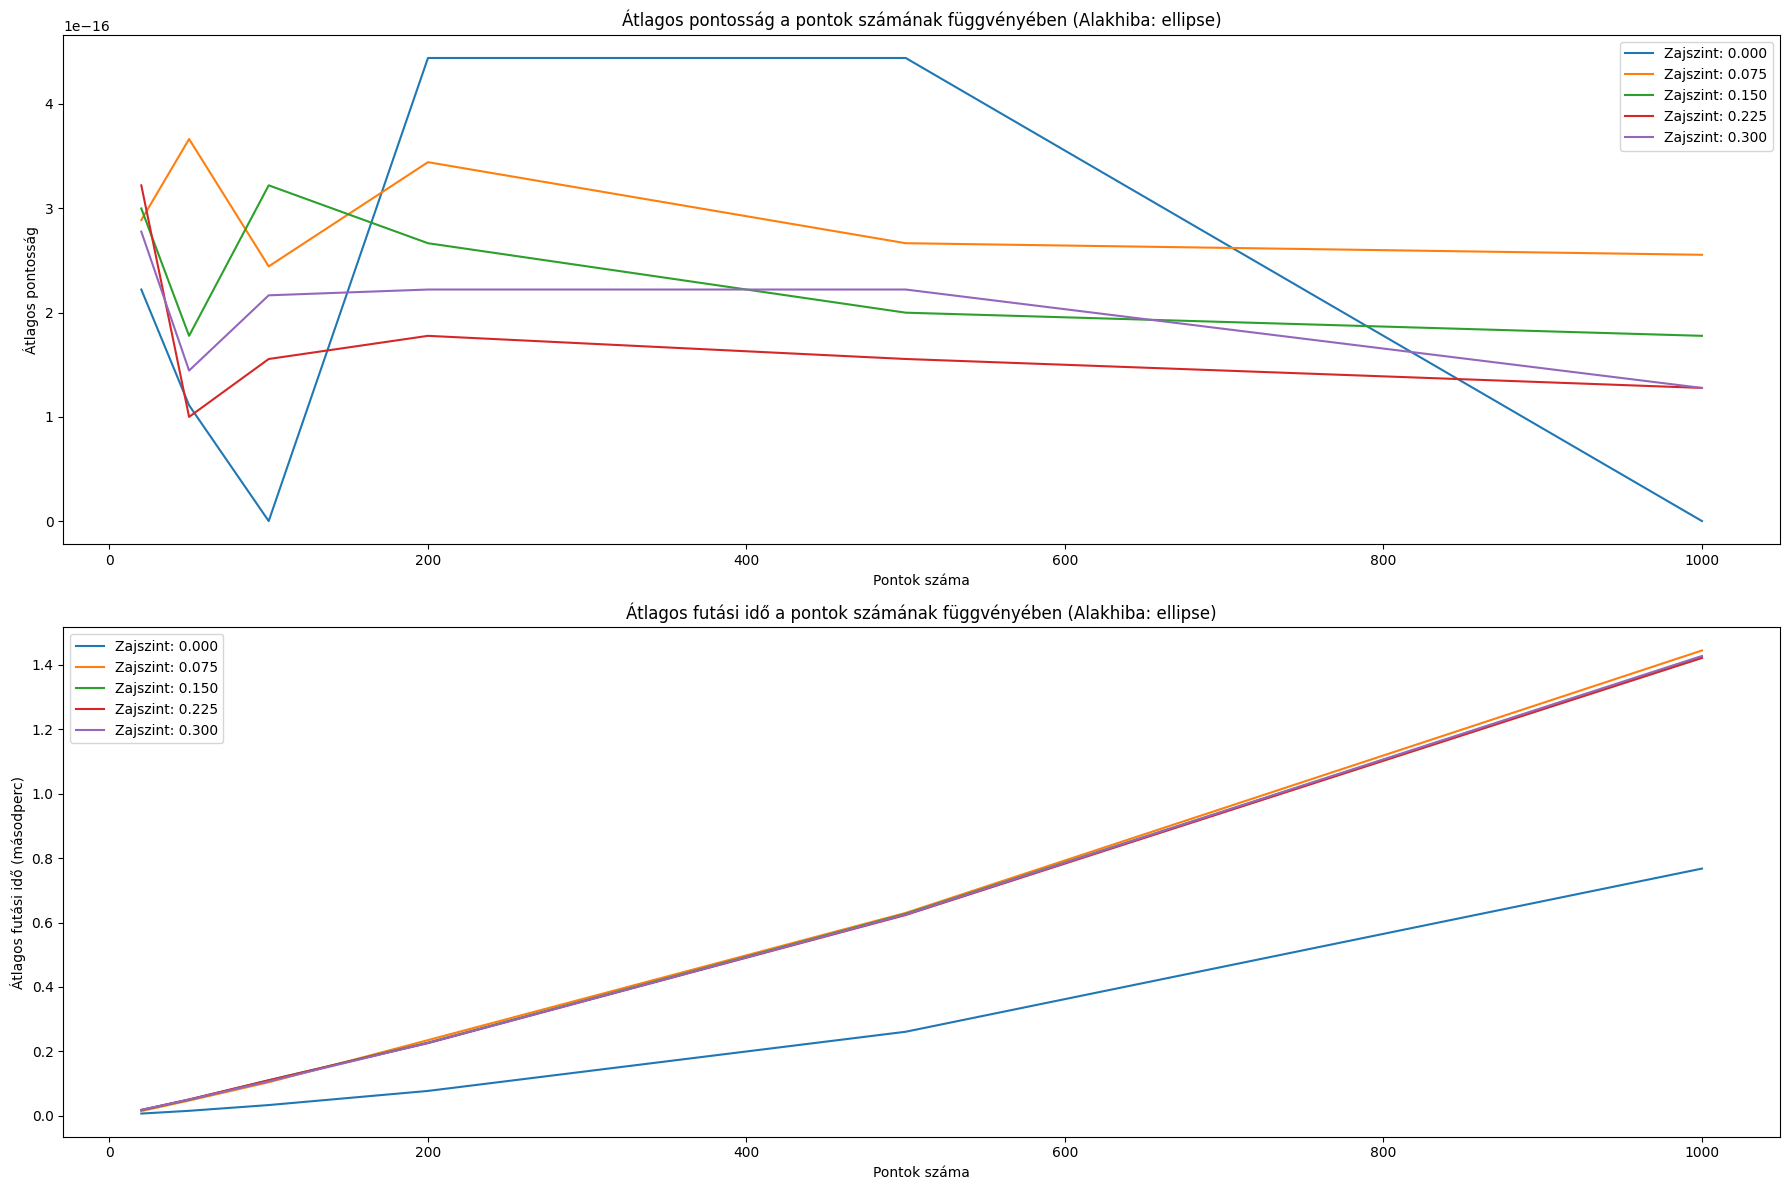

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
for noise_level in noise_levels:
    subset = df_mean[(df_mean['shape_error'] == 'None') & (df_mean['noise_level'] == noise_level)]
    plt.plot(subset['num_points'], subset['accuracy'], label=f'Noise level: {noise_level:.3f}')
plt.title('Average accuracy as a function of the number of points (No shape error)')
plt.xlabel('Number of points')
plt.ylabel('Average accuracy')
plt.legend()

plt.subplot(2, 1, 2)
for noise_level in noise_levels:
    subset = df_mean[(df_mean['shape_error'] == 'None') & (df_mean['noise_level'] == noise_level)]
    plt.plot(subset['num_points'], subset['max_inscribed_runtime_voronoi'], label=f'Noise level: {noise_level:.3f}')
plt.title('Average runtime as a function of the number of points (No shape error)')
plt.xlabel('Number of points')
plt.ylabel('Average runtime (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
for noise_level in noise_levels:
    subset = df_mean[(df_mean['shape_error'] == 'ellipse') & (df_mean['noise_level'] == noise_level)]
    plt.plot(subset['num_points'], subset['accuracy'], label=f'Noise level: {noise_level:.3f}')
plt.title('Average accuracy as a function of the number of points (Shape error: ellipse)')
plt.xlabel('Number of points')
plt.ylabel('Average accuracy')
plt.legend()

plt.subplot(2, 1, 2)
for noise_level in noise_levels:
    subset = df_mean[(df_mean['shape_error'] == 'ellipse') & (df_mean['noise_level'] == noise_level)]
    plt.plot(subset['num_points'], subset['max_inscribed_runtime_voronoi'], label=f'Noise level: {noise_level:.3f}')
plt.title('Average runtime as a function of the number of points (Shape error: ellipse)')
plt.xlabel('Number of points')
plt.ylabel('Average runtime (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

Summary

In [ ]:
results_pivot = df_mean.pivot_table(index='num_points', columns=['shape_error', 'noise_level'], values=['accuracy', 'max_inscribed_runtime_voronoi'])

results_pivot.columns = results_pivot.columns.set_levels(['Shape error: None' if x == 'None' else 'Shape error: Ellipse' if x == 'ellipse' else x for x in results_pivot.columns.levels[1]], level=1)
results_pivot.columns = results_pivot.columns.set_levels(['Average accuracy' if x == 'accuracy' else 'Average runtime (seconds)' if x == 'max_inscribed_runtime_voronoi' else x for x in results_pivot.columns.levels[0]], level=0)
results_pivot.columns.names = ['Metric', 'Shape error', 'Noise level']
results_pivot.index.name = 'Number of points'

results_pivot

Metrika      Átlagos pontosság                                            \
Alakhiba       Alakhiba: Nincs                                             
Zajszint                 0.000         0.075         0.150         0.225   
Pontok száma                                                               
20                0.000000e+00  3.774758e-16  3.885781e-16  4.107825e-16   
50                0.000000e+00  4.107825e-16  3.108624e-16  3.108624e-16   
100               2.220446e-16  3.219647e-16  2.886580e-16  1.665335e-16   
200               0.000000e+00  1.665335e-16  1.887379e-16  1.831868e-16   
500               0.000000e+00  2.664535e-16  1.665335e-16  1.276756e-16   
1000              0.000000e+00  3.885781e-16  2.331468e-16  1.165734e-16   

Metrika                                                                     \
Alakhiba                   Alakhiba: Ellipszis                               
Zajszint             0.300               0.000         0.075         0.150   
Pontok száma                                                                 
20            2.664535e-16        2.220446e-16  2.886580e-16  2.997602e-16   
50            2.997602e-16        1.110223e-16  3.663736e-16  1.776357e-16   
100           1.887379e-16        0.000000e+00  2.442491e-16  3.219647e-16   
200           1.665335e-16        4.440892e-16  3.441691e-16  2.664535e-16   
500           9.992007e-17        4.440892e-16  2.664535e-16  1.998401e-16   
1000          1.276756e-16        0.000000e+00  2.553513e-16  1.776357e-16   

Metrika                                  Átlagos futási idő (másodperc)  \
Alakhiba                                                Alakhiba: Nincs   
Zajszint             0.225         0.300                          0.000   
Pontok száma                                                              
20            3.219647e-16  2.775558e-16                       0.001914   
50            9.992007e-17  1.443290e-16                       0.002007   
100           1.554312e-16  2.164935e-16                       0.002544   
200           1.776357e-16  2.220446e-16                       0.003976   
500           1.554312e-16  2.220446e-16                       0.012660   
1000          1.276756e-16  1.276756e-16                       0.045374   

Metrika                                                                   \
Alakhiba                                             Alakhiba: Ellipszis   
Zajszint         0.075     0.150     0.225     0.300               0.000   
Pontok száma                                                               
20            0.015263  0.015973  0.017082  0.020850            0.007092   
50            0.047372  0.049588  0.049395  0.049791            0.015634   
100           0.109749  0.117816  0.110293  0.108234            0.033496   
200           0.275342  0.225195  0.228136  0.234173            0.077378   
500           0.630601  0.627056  0.623931  0.623546            0.261110   
1000          1.445480  1.424294  1.423909  1.423865            0.767598   

Metrika                                               
Alakhiba                                              
Zajszint         0.075     0.150     0.225     0.300  
Pontok száma                                          
20            0.014964  0.017916  0.018151  0.018582  
50            0.047518  0.049923  0.051047  0.050466  
100           0.104358  0.110485  0.110388  0.107077  
200           0.235057  0.227360  0.225804  0.226332  
500           0.629982  0.627159  0.623577  0.625223  
1000          1.444640  1.424415  1.421384  1.427649

## Evaluation of Results

### 1. Average Accuracy
- The accuracy has very small values, close to zero.
- In the case without shape error, the accuracy shows minimal fluctuation with changes in noise level. The presence of ellipse shape error does not result in significant accuracy differences either.
- As the number of points increases, the accuracy values remain stable, with no significant degradation due to noise levels or shape errors.

### 2. Average Runtime
- The runtime increases drastically with the number of points.
  - For example, at 20 points, the time is still less than 0.02 seconds, while at 1000 points, it exceeds 1.4 seconds.
- In cases without shape error, the runtime is slightly lower than in cases with ellipse shape error, especially at higher point counts.
- Increasing noise level also slightly slows down the runtime, but shape error has a much greater impact on it.

### Observations:
- **In terms of accuracy**: noise and shape error do not significantly affect the results.
- **In terms of runtime**: shape error and noise clearly increase the time, especially at higher point counts. The runtime practically increases linearly with the number of points.